Todo:

1. Problem statement
2. Required extra libraries and their installation instructions
3. Mention that hyper parameter tuning will take time when run

In [671]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
# setting display format so that large values are shown properly
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

sns.set_style(style='dark')
sns.set_context("notebook")

In [672]:
telecom_data = pd.read_csv('telecom_churn_data.csv')

In [673]:
telecom_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


In [674]:
def get_columns_with_nan_percentage(df):
    nan_cols = [{
        "column":
        c,
        "percentage":
        round(100 * (df[c].isnull().sum() / len(df[c].index)), 2),
        "type":
        df[c].dtype
    } for c in df.columns
                if round(100 *
                         (df[c].isnull().sum() / len(df[c].index)), 2) > 0]
    
    if len(nan_cols)>0:
        return pd.DataFrame.from_records(nan_cols).sort_values(by=['percentage'],
                                                           ascending=False)
    else:
        return pd.DataFrame.from_records(nan_cols)


def convert_to_category(columns):
    for column in columns:
        telecom_data[column] = telecom_data[column].astype('object')


def get_int_float_columns_with_Zero_percentage(df):
    nan_cols = [{
        "column":
        c,
        "percentage":
        round(100 * ((df[c] == 0).sum() / len(df[c].index)), 2),
        "type":
        df[c].dtype
    } for c in df.columns
                if round(100 *
                         ((df[c] == 0).sum().sum() / len(df[c].index)), 2) > 0]
    return pd.DataFrame.from_records(nan_cols)


def get_columns_with_similar_values(df, threshold):
    columns_to_delete = []
    for c in df.columns:
        if (any(y >= threshold for y in df[c].value_counts(
                dropna=False, normalize=True).tolist())):
            columns_to_delete.append(c)
    return columns_to_delete

## High value customers

In order to identify the high value customer, we need to find the customers who spent the most. For this we will use 
```
total_rech_data_6, av_rech_amt_data_6, total_rech_data_7 , av_rech_amt_data_7, total_rech_amt_6 and total_rech_amt_7
```


In [675]:
columns_high_value_calculation= ['total_rech_data_6', 'av_rech_amt_data_6', 'total_rech_data_7' , 'av_rech_amt_data_7', 'total_rech_amt_6', 'total_rech_amt_7']

telecom_data[columns_high_value_calculation].describe()

total_rech_data_6  av_rech_amt_data_6  total_rech_data_7  \
count         25153.0000          25153.0000         25571.0000   
mean              2.4638            192.6010             2.6664   
std               2.7891            192.6463             3.0316   
min               1.0000              1.0000             1.0000   
25%               1.0000             82.0000             1.0000   
50%               1.0000            154.0000             1.0000   
75%               3.0000            252.0000             3.0000   
max              61.0000           7546.0000            54.0000   

       av_rech_amt_data_7  total_rech_amt_6  total_rech_amt_7  
count          25571.0000        99999.0000        99999.0000  
mean             200.9813          327.5146          322.9630  
std              196.7912          398.0197          408.1142  
min                0.5000            0.0000            0.0000  
25%               92.0000          109.0000          100.0000  
50%              154.0000          230.0000          220.0000  
75%              252.0000          437.5000          428.0000  
max             4365.0000        35190.0000        40335.0000

In [676]:
nan_df = get_columns_with_nan_percentage(telecom_data[columns_high_value_calculation])
nan_df

column  percentage     type
0   total_rech_data_6     74.8500  float64
1  av_rech_amt_data_6     74.8500  float64
2   total_rech_data_7     74.4300  float64
3  av_rech_amt_data_7     74.4300  float64

If we see the minimum for each type of column, we can see it is 1. So, we can put 0 in case of NAN for the customers

In [677]:
telecom_data[columns_high_value_calculation] = telecom_data[columns_high_value_calculation].fillna(0)

In [678]:
# Similarly, we can also put 0 for month 8
telecom_data[['total_rech_data_8', 'av_rech_amt_data_8','total_rech_amt_8']] = telecom_data[['total_rech_data_8', 'av_rech_amt_data_8','total_rech_amt_8']].fillna(0)

In [679]:
def get_average_recharge(row):
    amount = 0.0
    amount += row['total_rech_data_6'] * row['av_rech_amt_data_6']
    amount += row['total_rech_data_7'] * row['av_rech_amt_data_7']
    amount += row['total_rech_amt_6']
    amount += row['total_rech_amt_7']

    return amount / 2.0


telecom_data['average_recharge_amount'] = telecom_data.apply(
    get_average_recharge, axis=1)

In [680]:
percentile_70 = telecom_data['average_recharge_amount'].quantile(.7)
percentile_70

478.0

In [681]:
# As per the problem statement, we need to consider customers as high value if they have more than 70 percentile expense

def check_high_value_customer(row):
    return 1 if row['average_recharge_amount'] > percentile_70 else 0


telecom_data['high_value_customer'] = telecom_data.apply(
    check_high_value_customer, axis=1)

In [682]:
telecom_data['high_value_customer'].value_counts()

0    70046
1    29953
Name: high_value_customer, dtype: int64

We can see that there are **29953** high value customer. From now onwards, we will only consider these customers for further analysis.

In [683]:
# Getting all the high value customers
telecom_data = telecom_data[telecom_data['high_value_customer'] == 1]

In [684]:
telecom_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29953 entries, 0 to 99997
Columns: 228 entries, mobile_number to high_value_customer
dtypes: float64(180), int64(36), object(12)
memory usage: 52.3+ MB


## Churned customers

In [685]:
def check_churn(row):
     return 1 if (row['total_ic_mou_9'] == 0 and row['total_og_mou_9'] == 0 and row['vol_2g_mb_9'] == 0 and row['vol_3g_mb_9'] == 0)  else 0

telecom_data['churn'] = telecom_data.apply(check_churn, axis=1)
telecom_data['churn'] = telecom_data['churn'].astype('category')

In [686]:
telecom_data['churn'].value_counts()

0    27520
1     2433
Name: churn, dtype: int64

Now we will delete columns for **September**

In [687]:
def get_columns_by_pattern(df,func):
    return [c for c in telecom_data.columns if func(c)]

telecom_data = telecom_data.drop('sep_vbc_3g',axis=1)

In [688]:
columns_to_drop = get_columns_by_pattern(telecom_data,
                                       lambda x: x.endswith("_9"))
telecom_data = telecom_data.drop(columns_to_drop, axis=1)

In [689]:
# We can delete the mobile number column as it will not help in analysis
telecom_data = telecom_data.drop('mobile_number',axis=1)

In [690]:
nan_df = get_columns_with_nan_percentage(telecom_data)
nan_df

column  percentage     type
118                 fb_user_8     46.8000  float64
112                 arpu_2g_8     46.8000  float64
100           max_rech_data_8     46.8000  float64
103           count_rech_2g_8     46.8000  float64
106           count_rech_3g_8     46.8000  float64
109                 arpu_3g_8     46.8000  float64
97   date_of_last_rech_data_8     46.8000   object
115          night_pck_user_8     46.8000  float64
116                 fb_user_6     44.1100  float64
110                 arpu_2g_6     44.1100  float64
101           count_rech_2g_6     44.1100  float64
98            max_rech_data_6     44.1100  float64
107                 arpu_3g_6     44.1100  float64
113          night_pck_user_6     44.1100  float64
95   date_of_last_rech_data_6     44.1100   object
104           count_rech_3g_6     44.1100  float64
105           count_rech_3g_7     43.1200  float64
99            max_rech_data_7     43.1200  float64
117                 fb_user_7     43.1200  float64
102           count_rech_2g_7     43.1200  float64
96   date_of_last_rech_data_7     43.1200   object
108                 arpu_3g_7     43.1200  float64
114          night_pck_user_7     43.1200  float64
111                 arpu_2g_7     43.1200  float64
79           std_ic_t2o_mou_8      3.9100  float64
46               std_og_mou_8      3.9100  float64
49               isd_og_mou_8      3.9100  float64
82               std_ic_mou_8      3.9100  float64
43           std_og_t2c_mou_8      3.9100  float64
55                og_others_8      3.9100  float64
76           std_ic_t2f_mou_8      3.9100  float64
52               spl_og_mou_8      3.9100  float64
73           std_ic_t2m_mou_8      3.9100  float64
40           std_og_t2f_mou_8      3.9100  float64
70           std_ic_t2t_mou_8      3.9100  float64
58           loc_ic_t2t_mou_8      3.9100  float64
67               loc_ic_mou_8      3.9100  float64
61           loc_ic_t2m_mou_8      3.9100  float64
85               spl_ic_mou_8      3.9100  float64
31               loc_og_mou_8      3.9100  float64
88               isd_ic_mou_8      3.9100  float64
64           loc_ic_t2f_mou_8      3.9100  float64
7                 onnet_mou_8      3.9100  float64
10               offnet_mou_8      3.9100  float64
13              roam_ic_mou_8      3.9100  float64
16              roam_og_mou_8      3.9100  float64
19           loc_og_t2t_mou_8      3.9100  float64
22           loc_og_t2m_mou_8      3.9100  float64
25           loc_og_t2f_mou_8      3.9100  float64
28           loc_og_t2c_mou_8      3.9100  float64
34           std_og_t2t_mou_8      3.9100  float64
91                ic_others_8      3.9100  float64
37           std_og_t2m_mou_8      3.9100  float64
94        date_of_last_rech_8      1.9400   object
77           std_ic_t2o_mou_6      1.8100  float64
86               isd_ic_mou_6      1.8100  float64
74           std_ic_t2f_mou_6      1.8100  float64
80               std_ic_mou_6      1.8100  float64
71           std_ic_t2m_mou_6      1.8100  float64
83               spl_ic_mou_6      1.8100  float64
68           std_ic_t2t_mou_6      1.8100  float64
89                ic_others_6      1.8100  float64
65               loc_ic_mou_6      1.8100  float64
59           loc_ic_t2m_mou_6      1.8100  float64
20           loc_og_t2m_mou_6      1.8100  float64
26           loc_og_t2c_mou_6      1.8100  float64
44               std_og_mou_6      1.8100  float64
23           loc_og_t2f_mou_6      1.8100  float64
47               isd_og_mou_6      1.8100  float64
35           std_og_t2m_mou_6      1.8100  float64
29               loc_og_mou_6      1.8100  float64
50               spl_og_mou_6      1.8100  float64
17           loc_og_t2t_mou_6      1.8100  float64
38           std_og_t2f_mou_6      1.8100  float64
53                og_others_6      1.8100  float64
14              roam_og_mou_6      1.8100  float64
56           loc_ic_t2t_mou_6      1.8100  float64
11              roam_ic_mou_6      1.8100  fl

Among the columns, following are categorical columns
```
fb_user_6,fb_user_7,fb_user_8,night_pck_user_6,night_pck_user_7,night_pck_user_8
```


In [691]:
categorical_columns = ['fb_user_6','fb_user_7','fb_user_8','night_pck_user_6','night_pck_user_7','night_pck_user_8']

In [692]:
# We will put -1 as a new category for the null in the above mentioned columns.

telecom_data[categorical_columns] = telecom_data[categorical_columns].fillna(-1)
telecom_data[categorical_columns] = telecom_data[categorical_columns].astype('int').astype('category')

In [693]:
telecom_data.describe()

circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou     arpu_6  \
count 29953.0000      29730.0000      29730.0000      29730.0000 29953.0000   
mean    109.0000          0.0000          0.0000          0.0000   558.8201   
std       0.0000          0.0000          0.0000          0.0000   460.8682   
min     109.0000          0.0000          0.0000          0.0000 -2258.7090   
25%     109.0000          0.0000          0.0000          0.0000   310.1420   
50%     109.0000          0.0000          0.0000          0.0000   482.3540   
75%     109.0000          0.0000          0.0000          0.0000   700.2400   
max     109.0000          0.0000          0.0000          0.0000 27731.0880   

          arpu_7     arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
count 29953.0000 29953.0000   29411.0000   29417.0000   28781.0000   
mean    561.1605   508.8903     265.7089     272.9359     243.8881   
std     480.0285   502.1363     462.6927     483.2821     465.5056   
min   -2014.0450  -945.8080       0.0000       0.0000       0.0000   
25%     310.0710   231.6150      19.2500      18.1800      14.2800   
50%     481.4960   427.6040      88.1400      86.8900      72.9900   
75%     698.8290   661.7530     297.4900     298.3800     255.3100   
max   35145.8340 33543.6240    7376.7100    8157.7800   10752.5600   

       offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
count    29411.0000    29417.0000    28781.0000     29411.0000     29417.0000   
mean       380.6890      385.1248      348.7697        16.4211        12.8766   
std        484.4411      501.0241      486.8370        77.0128        76.5019   
min          0.0000        0.0000        0.0000         0.0000         0.0000   
25%         78.5500       76.1800       58.7600         0.0000         0.0000   
50%        229.6300      227.1300      197.6900         0.0000         0.0000   
75%        494.7550      500.4800      455.4400         0.0000         0.0000   
max       8362.3600     9667.1300    14007.3400      2613.3100      3813.2900   

       roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
count     28781.0000     29411.0000     29417.0000     28781.0000   
mean         13.0218        27.0862        20.5224        20.6992   
std          75.6306       117.2841        96.9672       106.8338   
min           0.0000         0.0000         0.0000         0.0000   
25%           0.0000         0.0000         0.0000         0.0000   
50%           0.0000         0.0000         0.0000         0.0000   
75%           0.0000         0.0000         0.0000         0.0000   
max        4169.8100      3775.1100      2812.0400      5337.0400   

       loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  \
count        29411.0000        29417.0000        28781.0000        29411.0000   
mean            86.1327           87.3255           81.3358          166.3191   
std            230.7725          242.6041          231.5687          251.5209   
min              0.0000            0.0000            0.0000            0.0000   
25%              5.0300            5.2900            3.8400           21.1300   
50%             25.5900           25.7900           23.2600           80.3400   
75%             79.8700           80.4400           76.1100          212.4850   
max           6431.3300         7400.6600        10752.5600         4729.7400   

       loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  \
count        29417.0000        28781.0000        29411.0000        29417.0000   
mean           166.0592          157.9920            6.4653            6.5436   
std            242.8614          236.4004           22.3257           22.1390   
min              0.0000            0.0000            0.0000            0.0000   
25%             22.9400           17.5800            0.0000            0.0000   
50%             81.7400           74.6600            0.1100            0.2100   
75%            

In [694]:
nan_df = get_columns_with_nan_percentage(telecom_data)
nan_df

column  percentage     type
112                 arpu_2g_8     46.8000  float64
106           count_rech_3g_8     46.8000  float64
97   date_of_last_rech_data_8     46.8000   object
103           count_rech_2g_8     46.8000  float64
100           max_rech_data_8     46.8000  float64
109                 arpu_3g_8     46.8000  float64
101           count_rech_2g_6     44.1100  float64
104           count_rech_3g_6     44.1100  float64
98            max_rech_data_6     44.1100  float64
107                 arpu_3g_6     44.1100  float64
110                 arpu_2g_6     44.1100  float64
95   date_of_last_rech_data_6     44.1100   object
102           count_rech_2g_7     43.1200  float64
99            max_rech_data_7     43.1200  float64
105           count_rech_3g_7     43.1200  float64
111                 arpu_2g_7     43.1200  float64
96   date_of_last_rech_data_7     43.1200   object
108                 arpu_3g_7     43.1200  float64
79           std_ic_t2o_mou_8      3.9100  float64
40           std_og_t2f_mou_8      3.9100  float64
46               std_og_mou_8      3.9100  float64
76           std_ic_t2f_mou_8      3.9100  float64
43           std_og_t2c_mou_8      3.9100  float64
37           std_og_t2m_mou_8      3.9100  float64
73           std_ic_t2m_mou_8      3.9100  float64
67               loc_ic_mou_8      3.9100  float64
70           std_ic_t2t_mou_8      3.9100  float64
49               isd_og_mou_8      3.9100  float64
34           std_og_t2t_mou_8      3.9100  float64
52               spl_og_mou_8      3.9100  float64
64           loc_ic_t2f_mou_8      3.9100  float64
55                og_others_8      3.9100  float64
61           loc_ic_t2m_mou_8      3.9100  float64
82               std_ic_mou_8      3.9100  float64
58           loc_ic_t2t_mou_8      3.9100  float64
19           loc_og_t2t_mou_8      3.9100  float64
7                 onnet_mou_8      3.9100  float64
31               loc_og_mou_8      3.9100  float64
88               isd_ic_mou_8      3.9100  float64
10               offnet_mou_8      3.9100  float64
13              roam_ic_mou_8      3.9100  float64
28           loc_og_t2c_mou_8      3.9100  float64
91                ic_others_8      3.9100  float64
85               spl_ic_mou_8      3.9100  float64
25           loc_og_t2f_mou_8      3.9100  float64
22           loc_og_t2m_mou_8      3.9100  float64
16              roam_og_mou_8      3.9100  float64
94        date_of_last_rech_8      1.9400   object
83               spl_ic_mou_6      1.8100  float64
62           loc_ic_t2f_mou_6      1.8100  float64
65               loc_ic_mou_6      1.8100  float64
71           std_ic_t2m_mou_6      1.8100  float64
68           std_ic_t2t_mou_6      1.8100  float64
74           std_ic_t2f_mou_6      1.8100  float64
59           loc_ic_t2m_mou_6      1.8100  float64
77           std_ic_t2o_mou_6      1.8100  float64
80               std_ic_mou_6      1.8100  float64
86               isd_ic_mou_6      1.8100  float64
89                ic_others_6      1.8100  float64
56           loc_ic_t2t_mou_6      1.8100  float64
32           std_og_t2t_mou_6      1.8100  float64
14              roam_og_mou_6      1.8100  float64
35           std_og_t2m_mou_6      1.8100  float64
26           loc_og_t2c_mou_6      1.8100  float64
38           std_og_t2f_mou_6      1.8100  float64
23           loc_og_t2f_mou_6      1.8100  float64
41           std_og_t2c_mou_6      1.8100  float64
20           loc_og_t2m_mou_6      1.8100  float64
44               std_og_mou_6      1.8100  float64
47               isd_og_mou_6      1.8100  float64
17           loc_og_t2t_mou_6      1.8100  float64
50               spl_og_mou_6      1.8100  float64
11              roam_ic_mou_6      1.8100  float64
53                og_others_6      1.8100  float64
8                offnet_mou_6      1.8100  float64
5                 onnet_mou_6      1.8100  float64
29               loc_og_mou_6      1.8100  float64
12              roam_ic_mou_7      1.7900  fl

We can see many columns which has count in them and have NAN. We can put 0 as the default value for such columns

In [695]:
counts_column = get_columns_by_pattern(telecom_data,
                                       lambda x: x.startswith('count_'))
telecom_data[counts_column] = telecom_data[counts_column].fillna(0)

In [696]:
def segregate_columns(df, n=10):
    segregation = [{
        "col": c,
        "col_type": 'continuous' if df[c].nunique(dropna=False) > n else 'categorical',
        "unique_count": df[c].nunique(dropna=False),
         "na_percentage": round(100 * (df[c].isnull().sum() / len(df[c].index)), 2),
    } for c in df.columns]
    return pd.DataFrame.from_records(segregation).sort_values(by=['unique_count'],
                                                           ascending=True).reset_index()

In [697]:
nan_df_numerical = nan_df[nan_df['type'] == 'float64']['column']
nan_df_numerical

112           arpu_2g_8
106     count_rech_3g_8
103     count_rech_2g_8
100     max_rech_data_8
109           arpu_3g_8
101     count_rech_2g_6
104     count_rech_3g_6
98      max_rech_data_6
107           arpu_3g_6
110           arpu_2g_6
102     count_rech_2g_7
99      max_rech_data_7
105     count_rech_3g_7
111           arpu_2g_7
108           arpu_3g_7
79     std_ic_t2o_mou_8
40     std_og_t2f_mou_8
46         std_og_mou_8
76     std_ic_t2f_mou_8
43     std_og_t2c_mou_8
37     std_og_t2m_mou_8
73     std_ic_t2m_mou_8
67         loc_ic_mou_8
70     std_ic_t2t_mou_8
49         isd_og_mou_8
34     std_og_t2t_mou_8
52         spl_og_mou_8
64     loc_ic_t2f_mou_8
55          og_others_8
61     loc_ic_t2m_mou_8
82         std_ic_mou_8
58     loc_ic_t2t_mou_8
19     loc_og_t2t_mou_8
7           onnet_mou_8
31         loc_og_mou_8
88         isd_ic_mou_8
10         offnet_mou_8
13        roam_ic_mou_8
28     loc_og_t2c_mou_8
91          ic_others_8
85         spl_ic_mou_8
25     loc_og_t2

We can see that there are many columns which are float and have NAN. We can fill them with 0

In [698]:
telecom_data[nan_df_numerical] = telecom_data[nan_df_numerical].fillna(0)

In [699]:
nan_df = get_columns_with_nan_percentage(telecom_data)
nan_df

column  percentage    type
7  date_of_last_rech_data_8     46.8000  object
5  date_of_last_rech_data_6     44.1100  object
6  date_of_last_rech_data_7     43.1200  object
4       date_of_last_rech_8      1.9400  object
1      last_date_of_month_8      0.5500  object
3       date_of_last_rech_7      0.3300  object
2       date_of_last_rech_6      0.2400  object
0      last_date_of_month_7      0.0900  object

We will be deleting the date columns as there is no significance use of these columns and we have multiple other columns which have correlation with them like number of recharge etc.


In [700]:
date_columns_to_drop = get_columns_by_pattern(telecom_data,lambda x: 'date' in x)
telecom_data = telecom_data.drop(date_columns_to_drop, axis=1)

In [701]:
nan_df = get_columns_with_nan_percentage(telecom_data)
nan_df

Empty DataFrame
Columns: []
Index: []

We can see now there are no columns with NAN

## Deleting column with no variance

In [702]:
columns_with_more_than_100_percent_same_value = get_columns_with_similar_values(telecom_data,1)
columns_with_more_than_100_percent_same_value

['circle_id',
 'loc_og_t2o_mou',
 'std_og_t2o_mou',
 'loc_ic_t2o_mou',
 'std_og_t2c_mou_6',
 'std_og_t2c_mou_7',
 'std_og_t2c_mou_8',
 'std_ic_t2o_mou_6',
 'std_ic_t2o_mou_7',
 'std_ic_t2o_mou_8',
 'high_value_customer']

In [703]:
telecom_data = telecom_data.drop(columns_with_more_than_100_percent_same_value,
                                 axis=1)

In [704]:
telecom_data.shape

(29953, 153)

## New derived features

In [705]:
# Creating new columns for the month wise amount spent
def month_wise_amount_spent(row, month):
    return row['total_rech_amt_' + month] + (row['total_rech_data_' + month] *
                                             row['av_rech_amt_data_' + month])

In [706]:
telecom_data['total_amount_spent_6'] = telecom_data.apply(
    month_wise_amount_spent, args=('6'), axis=1)
telecom_data['total_amount_spent_7'] = telecom_data.apply(
    month_wise_amount_spent, args=('7'), axis=1)
telecom_data['total_amount_spent_8'] = telecom_data.apply(
    month_wise_amount_spent, args=('8'), axis=1)

Now we can delete the columns which we used to calculate the total monthly amount.

In [707]:
telecom_data = telecom_data.drop([
    'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
    'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8',
    'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8',
    'total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8',
    'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8', 'max_rech_data_6',
    'max_rech_data_7', 'max_rech_data_8'
],
                                 axis=1)

As we have added average amount for month of June and July, we can drop the total amount spent column.

In [708]:
telecom_data = telecom_data.drop(
    ['total_amount_spent_6', 'total_amount_spent_7'], axis=1)

In [709]:
telecom_data.shape

(29953, 136)

In [710]:
def merge_column_by_month(df, pattern, month, final_column_name):
    value = 0
    for p in pattern:
        value += value + df[p + month]
    df[final_column_name + month] = value

In [711]:
# We can derive new column total_data_mb_* for each month by combining 2g and 3g data
for m in ['6', '7', '8']:
    merge_column_by_month(telecom_data, ['vol_2g_mb_', 'vol_3g_mb_'], m,
                          'total_data_mb_')

In [712]:
# We can derive new column total_recharge_count_* for each month by combining 2g and 3g data recharge count
for m in ['6', '7', '8']:
    merge_column_by_month(telecom_data, ['count_rech_3g_', 'count_rech_3g_'], m,
                          'total_recharge_count_')

In [713]:
# We can derive new column total_arpu_data_* for each month by combining 2g and 3g arpu
for m in ['6', '7', '8']:
    merge_column_by_month(telecom_data, ['arpu_3g_', 'arpu_2g_'], m,
                          'total_arpu_data_')

In [714]:
# We can derive new column total_sachet_data_* for each month by combining 2g and 3g sachet
for m in ['6', '7', '8']:
    merge_column_by_month(telecom_data, ['sachet_3g_', 'sachet_2g_'], m,
                          'total_sachet_data_')

As we have created new combined columns, we can drop the individual columns

In [715]:
telecom_data = telecom_data.drop([
    'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'vol_3g_mb_6', 'vol_3g_mb_7',
    'vol_3g_mb_8', 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8',
    'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'arpu_3g_6',
    'arpu_3g_7', 'arpu_3g_8', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8',
    'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8', 'sachet_2g_6', 'sachet_2g_7',
    'sachet_2g_8'
],
                                 axis=1)

In [716]:
telecom_data.shape

(29953, 124)

## Analysis of the data
Reference for the following methods: https://towardsdatascience.com/a-starter-pack-to-exploratory-data-analysis-with-python-pandas-seaborn-and-scikit-learn-a77889485baf#89dd and the previous assignments.

In [717]:
default_figsize = (15, 5)
default_xtick_angle = 50

In [718]:
def categorical_summarized(dataframe,
                           x=None,
                           y=None,
                           hue=None,
                           palette='Set1',
                           verbose=True,
                           figsize=default_figsize,
                           title="",
                           xlabel=None,
                           ylabel=None,
                           rotate_labels=False):
    '''
    Helper function that gives a quick summary of a given column of categorical data
    Arguments
    =========
    dataframe: pandas dataframe
    x: str. horizontal axis to plot the labels of categorical data, y would be the count
    y: str. vertical axis to plot the labels of categorical data, x would be the count
    hue: str. if you want to compare it another variable (usually the target variable)
    palette: array-like. Colour of the plot
    Returns
    =======
    Quick Stats of the data and also the count plot
    '''
    if x == None:
        column_interested = y
    else:
        column_interested = x
    series = dataframe[column_interested]

    if verbose:
        print(series.describe())
        print('mode: ', series.mode())
        print('=' * 80)
        print(series.value_counts())

    sns.set(rc={'figure.figsize': figsize})
    sorted_df = dataframe.sort_values(column_interested)
    ax = sns.countplot(x=x, y=y, hue=hue, data=sorted_df)

    plt.title(title)
    if not xlabel:
        xlabel = column_interested
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    total = len(dataframe[column_interested])
    if rotate_labels:
        plt.setp(ax.get_xticklabels(),
                 rotation=30,
                 horizontalalignment='right')
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height() / 2
        ax.annotate(percentage, (x, y))
    plt.tight_layout()
    plt.style.use('fivethirtyeight')
    plt.xticks(rotation=default_xtick_angle)
    plt.show()

In [719]:
def quantitative_summarized(dataframe,
                            x=None,
                            y=None,
                            hue=None,
                            palette='Set1',
                            ax=None,
                            verbose=True,
                            swarm=False,
                            figsize=default_figsize):
    '''
    Helper function that gives a quick summary of quantattive data
    Arguments
    =========
    dataframe: pandas dataframe
    x: str. horizontal axis to plot the labels of categorical data (usually the target variable)
    y: str. vertical axis to plot the quantitative data
    hue: str. if you want to compare it another categorical variable (usually the target variable if x is another variable)
    palette: array-like. Colour of the plot
    swarm: if swarm is set to True, a swarm plot would be overlayed
    Returns
    =======
    Quick Stats of the data and also the box plot of the distribution
    '''
    series = dataframe[y]
    print(series.describe())
    if verbose:
        print('mode: ', series.mode())
        print('=' * 80)
        print(series.value_counts())
    sns.set(rc={'figure.figsize': figsize})

    sns.boxplot(x=x, y=y, hue=hue, data=dataframe, palette=palette, ax=ax)

    if swarm:
        sns.swarmplot(x=x,
                      y=y,
                      hue=hue,
                      data=dataframe,
                      palette=palette,
                      ax=ax)
    plt.tight_layout()
    plt.style.use('fivethirtyeight')
    plt.xticks(rotation=default_xtick_angle)
    plt.show()

In [720]:
def plot_column(df,
                col,
                chart_type='Hist',
                dtype=int,
                bins=25,
                figsize=default_figsize):
    temp_df = df[col]
    sns.set(rc={'figure.figsize': figsize})
    if chart_type == 'Hist':
        ax = sns.countplot(temp_df)
    elif chart_type == 'Dens':
        ax = sns.distplot(temp_df)
    xmin, xmax = ax.get_xlim()
    ax.set_xticks(np.round(np.linspace(xmin, xmax, bins), 2))
    plt.tight_layout()
    plt.locator_params(axis='y', nbins=6)
    plt.xticks(rotation=default_xtick_angle)
    plt.style.use('fivethirtyeight')
    plt.show()

In [721]:
def univariate_analysis(col,
                        chart_type='Dens',
                        df=telecom_data,
                        is_categorical=False,
                        title="",
                        xlabel=None,
                        ylabel=None,
                        rotate_labels=False,
                        bins=25):
    if is_categorical:
        categorical_summarized(df,
                               x=col,
                               title=title,
                               xlabel=xlabel,
                               ylabel=ylabel,
                               rotate_labels=rotate_labels,
                               verbose=False)
    else:
        quantitative_summarized(df, y=col, verbose=False)
        plot_column(df, col, chart_type=chart_type, bins=bins)

In [722]:
c_palette = ['tab:green', 'tab:red']

In [723]:
def bivariate_analysis(x,
                          hue,
                          df=telecom_data,
                          is_categorical=False,
                          title="",
                          xlabel=None,
                          ylabel=None,
                          rotate_labels=False,
                          bins=25):
    colors_list = ['green', 'red']
    temp = telecom_data[[x, hue]]
    temp = pd.crosstab(temp[x], temp[hue], margins=False)

    # Change this line to plot percentages instead of absolute values
    ax = (temp.div(temp.sum(1), axis=0)).plot(kind='bar',
                                              figsize=(15, 4),
                                              width=0.8,
                                              color=colors_list,
                                              edgecolor=None)
    plt.legend(labels=['Not churned', 'Churned'], fontsize=14)
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(fontsize=14)
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    plt.yticks([])

    # Add this loop to add the annotations
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        ax.annotate('{:.0%}'.format(height), (x, y + height + 0.01))

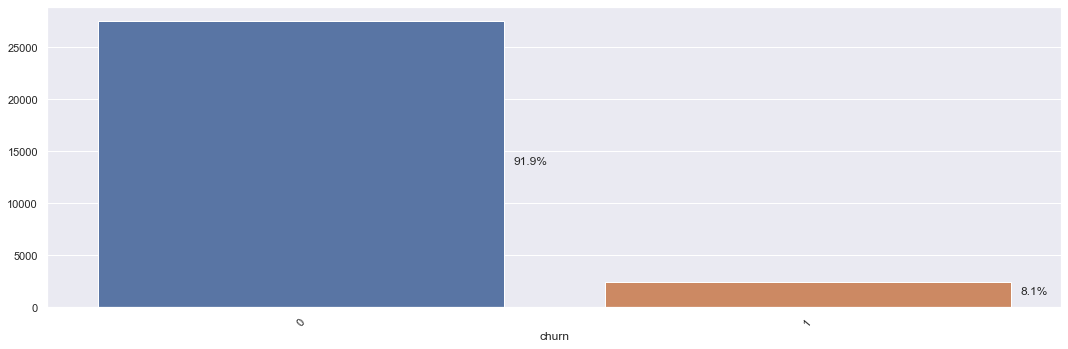

In [724]:
univariate_analysis('churn', is_categorical=True)

We can see that this data is highly imbalanced as the positive class (churn=1) is very less in number compared to negative class (churn=0). We will use class imbalance techniques like SMOTE to balance the data once we start with the model creation.

count   29953.0000
mean     1209.2806
std       957.4494
min       180.0000
25%       460.0000
50%       846.0000
75%      1756.0000
max      4321.0000
Name: aon, dtype: float64


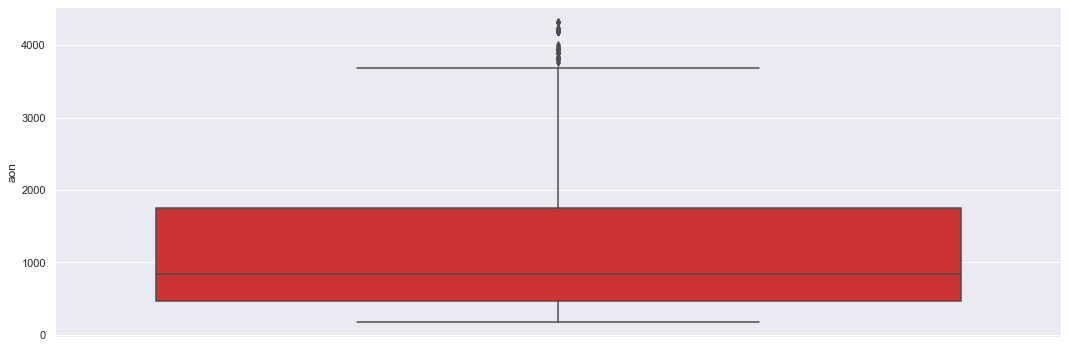

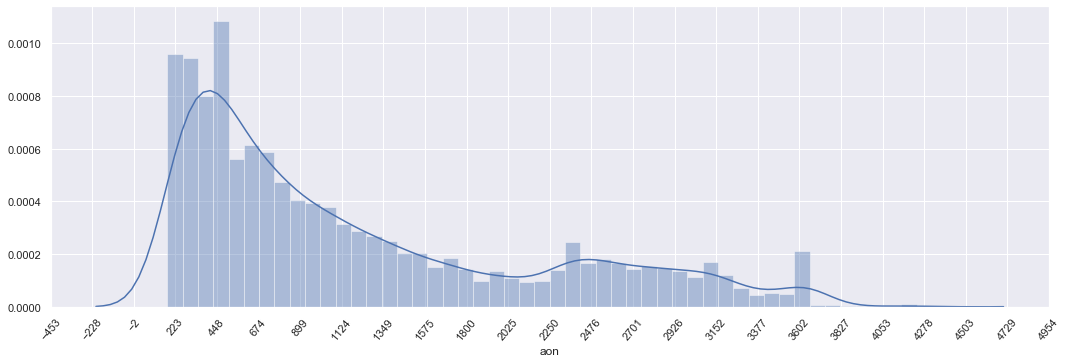

In [726]:
univariate_analysis('aon')

We can see that the all the customers are with the company for than a half year.
We can create a column which will have the age on the network in years.

In [727]:
telecom_data['aon_year'] = telecom_data['aon'].apply(lambda x: x//365)
telecom_data['aon_year'] = telecom_data['aon_year'].astype('category')
telecom_data = telecom_data.drop('aon',axis=1)

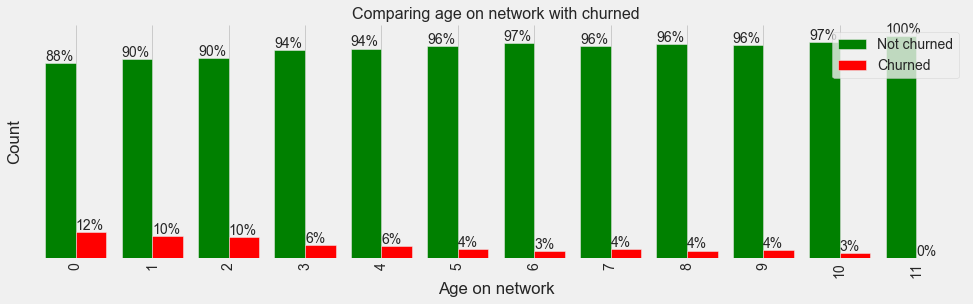

In [728]:
bivariate_analysis('aon_year',
                   'churn',
                   title="Comparing age on network with churned",
                   xlabel='Age on network',
                   ylabel='Count')

We can see as the age on network increases the churn rate decreases. Most churn happens in the starting 2 years.

Now, we will various features averaged for each (Jun, July and Aug)

In [729]:
def month_wise_analysis(columns, title, xlabel, ylabel, df=telecom_data):
    plot1 = plt.figure(1)
    sns.boxplot(x="variable", y="value", data=pd.melt(df[columns]))
    plt.show()
    means = df.groupby('churn')[columns].mean()
    means.rename(columns={means.columns[0]: "Jun", means.columns[1]: "Jul", means.columns[2]: "Aug"}, inplace=True)
    print(means)
    plot2 = plt.figure(1)
    plt.plot(means.T)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(['Non-Churn', 'Churn'])
    plt.show()

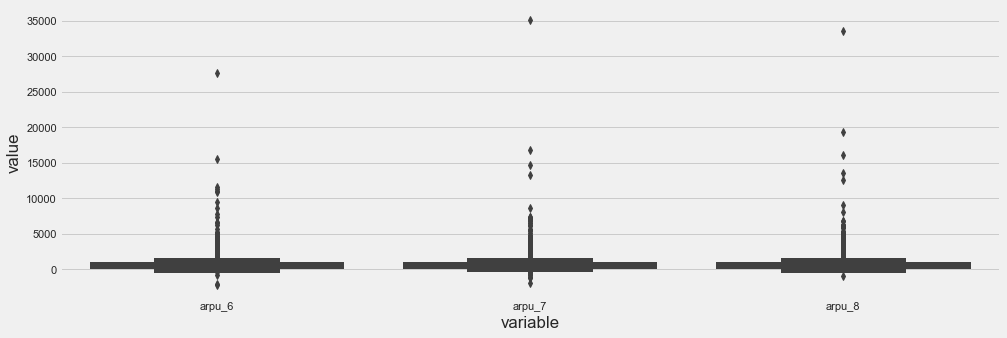

           Jun      Jul      Aug
churn                           
0     549.5470 562.9300 532.8697
1     663.7094 541.1461 237.6555


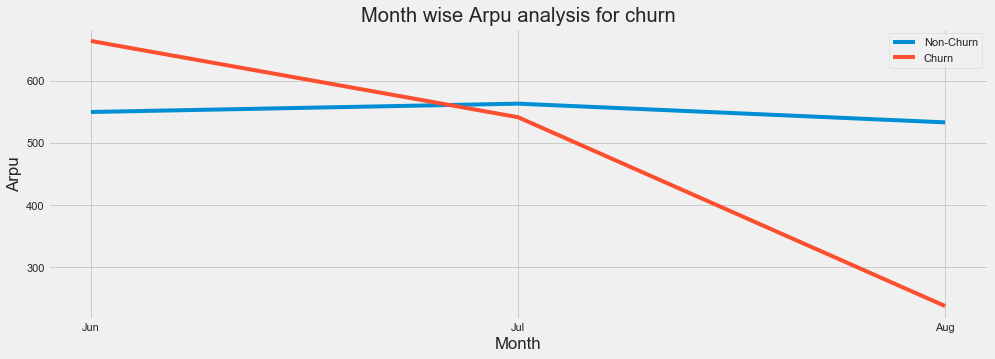

In [730]:
month_wise_analysis(['arpu_6', 'arpu_7', 'arpu_8'],
                    'Month wise Arpu analysis for churn', 'Month', 'Arpu')

We can see that the average revenue decreases significantly for the churned customer from Jun to Aug. In case of non-churned customers it is almost constant. We can see there are outliers. We will treat them in outliers treatment section.

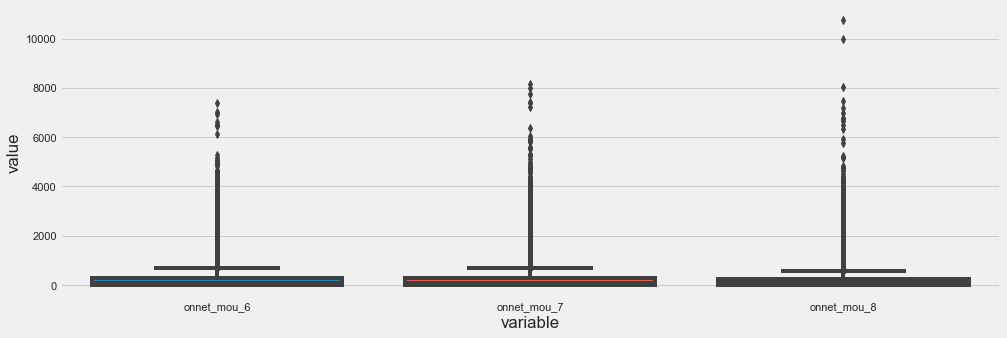

           Jun      Jul      Aug
churn                           
0     251.3741 265.8597 245.0309
1     368.6594 292.8466 113.4780


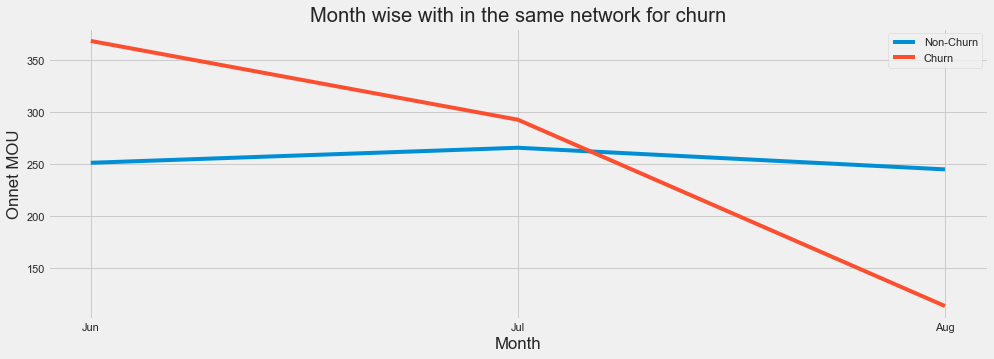

In [731]:
month_wise_analysis(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8'],
                    'Month wise with in the same network for churn', 'Month', 'Onnet MOU')

We can see that the average revenue decreases significantly for the churned customer from Jun to Aug. In case of non-churned customers it is almost constant. We can see there are outliers. We will treat them in outliers treatment section.

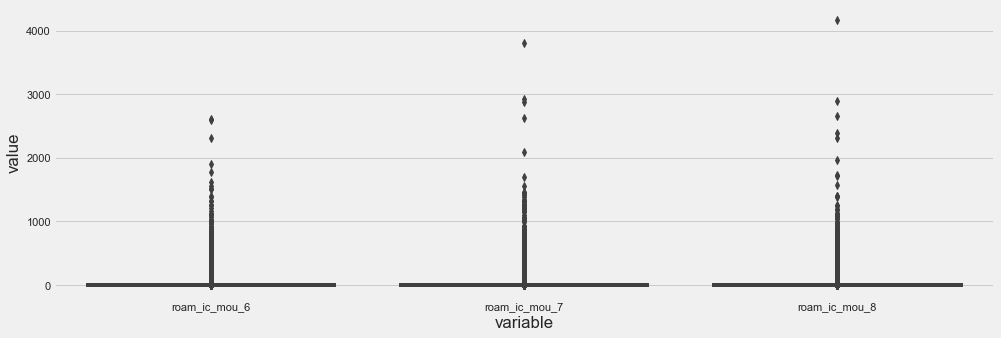

          Jun     Jul     Aug
churn                        
0     14.9823 11.1138 11.2065
1     29.0377 29.9788 27.2821


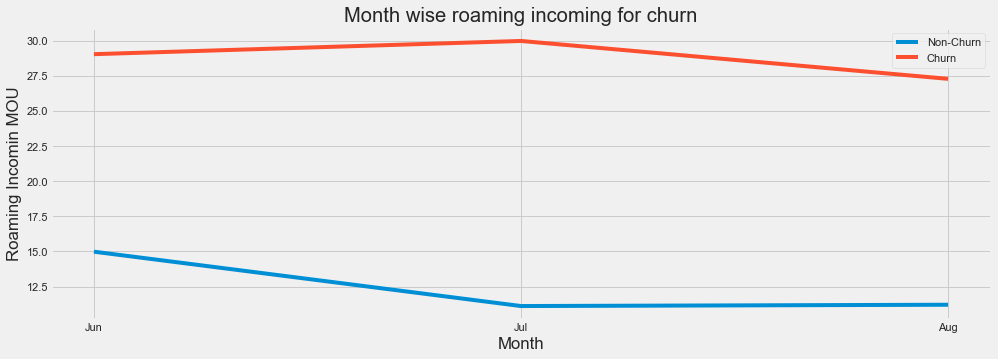

In [732]:
month_wise_analysis(['roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8'],
                    'Month wise roaming incoming for churn', 'Month', 'Roaming Incomin MOU')

We can see that the customers who churned had high roaming incoming usage. Hence, a better pack or deal on incoming roaming can be given to stop the churn.

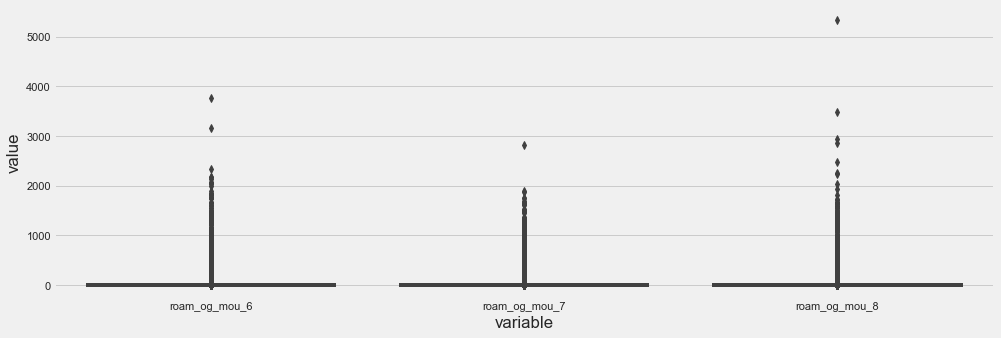

          Jun     Jul     Aug
churn                        
0     24.3533 17.5008 17.7816
1     51.9642 50.1792 43.7300


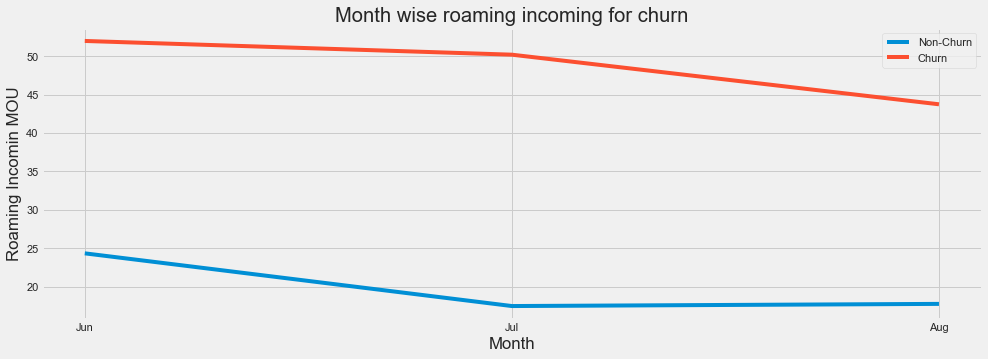

In [733]:
month_wise_analysis(['roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8'],
                    'Month wise roaming incoming for churn', 'Month', 'Roaming Incomin MOU')

We can see that the customers who churned had high roaming outgoing usage. Hence, a better pack or deal on outgoing roaming can be given to stop the churn.

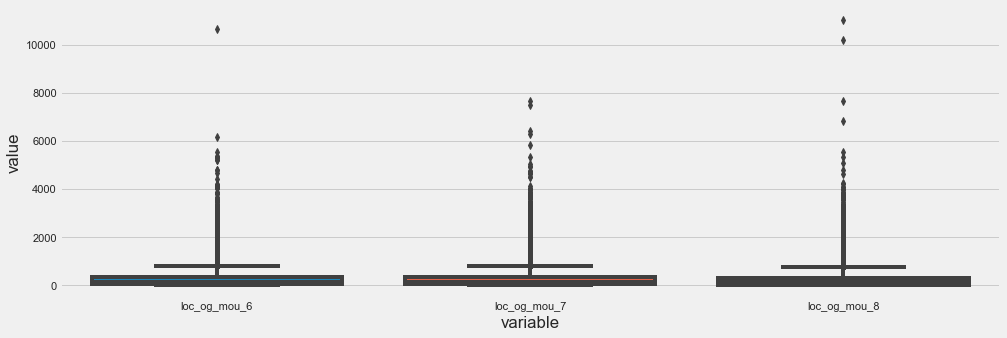

           Jun      Jul      Aug
churn                           
0     261.1244 265.7696 252.3358
1     176.3724 136.6957  49.5382


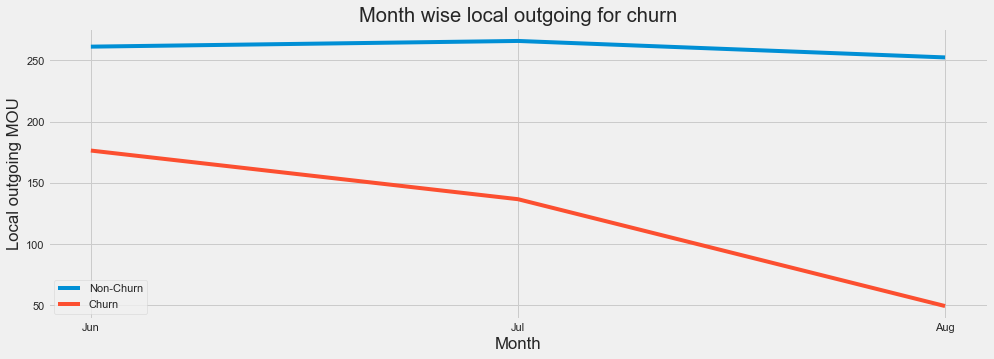

In [734]:
month_wise_analysis(['loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8'],
                    'Month wise local outgoing for churn', 'Month', 'Local outgoing MOU')

We can see the local outgoing usage for the churn customer is decreasing as the time increases. The company can provide pack etc to encourage more outgoing calls.

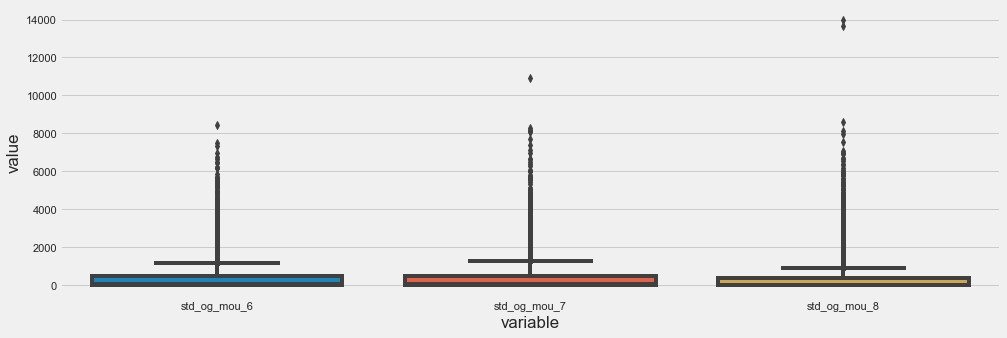

           Jun      Jul      Aug
churn                           
0     324.5269 353.8073 320.8792
1     603.0072 481.4109 156.1696


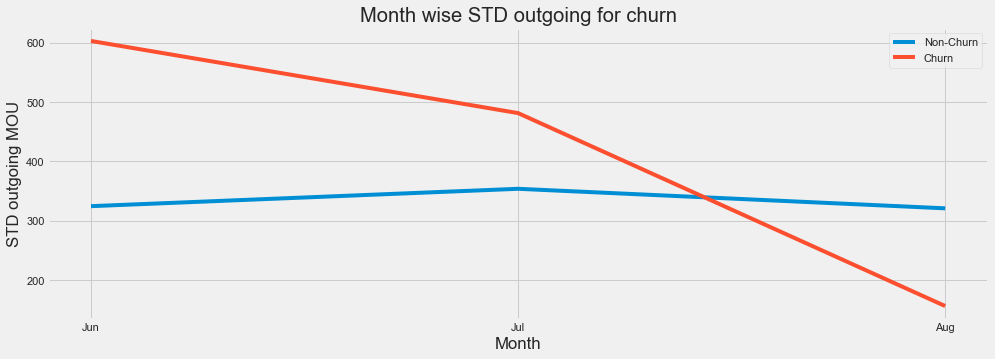

In [735]:
month_wise_analysis(['std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8'],
                    'Month wise STD outgoing for churn', 'Month', 'STD outgoing MOU')

We can see the std outgoing usage for the churn customer is decreasing as the time increases. The company can provide pack etc to encourage more std outgoing calls.

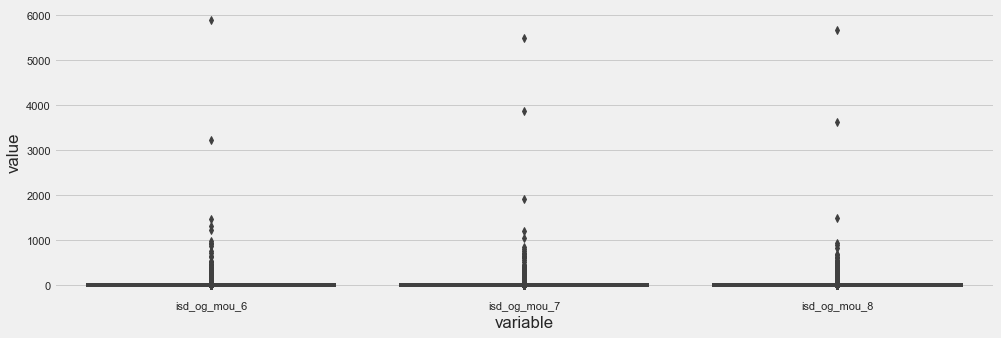

         Jun    Jul    Aug
churn                     
0     1.9827 2.0180 2.0148
1     4.3501 3.1390 1.2425


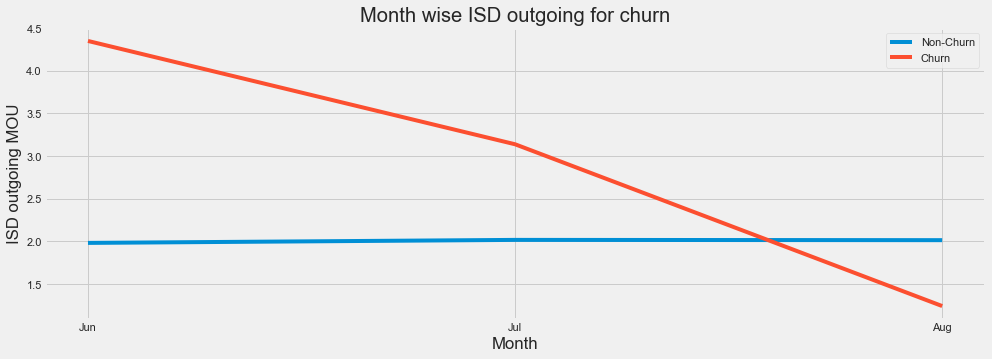

In [736]:
month_wise_analysis(['isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8'],
                    'Month wise ISD outgoing for churn', 'Month', 'ISD outgoing MOU')

We can see the ISD outgoing usage for the churn customer is decreasing as the time increases. The company can provide pack etc to encourage more ISD outgoing calls.

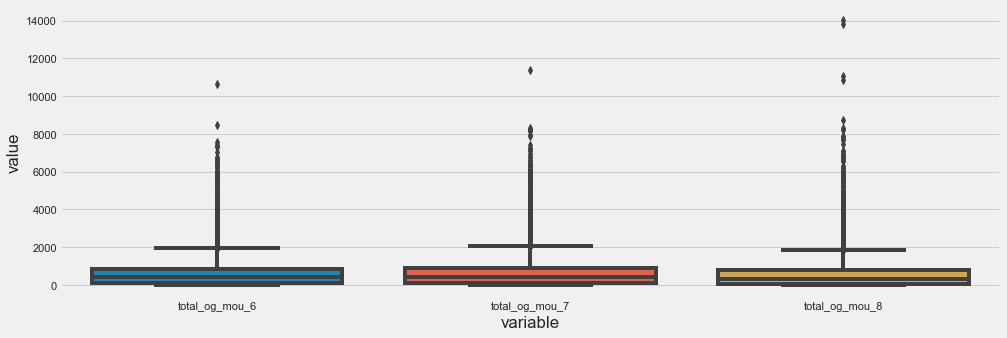

           Jun      Jul      Aug
churn                           
0     593.9961 628.7205 582.1774
1     791.7370 628.7653 209.7945


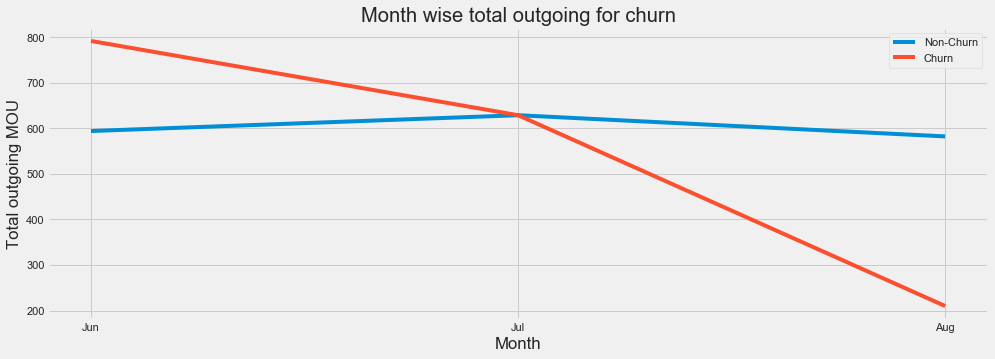

In [737]:
month_wise_analysis(['total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8'],
                    'Month wise total outgoing for churn', 'Month', 'Total outgoing MOU')

We can see that the total outgoing mou decreases significantly for the churned customer from Jun to Aug. In case of non-churned customers it is almost constant. We can see there are outliers. We will treat them in outliers treatment section.

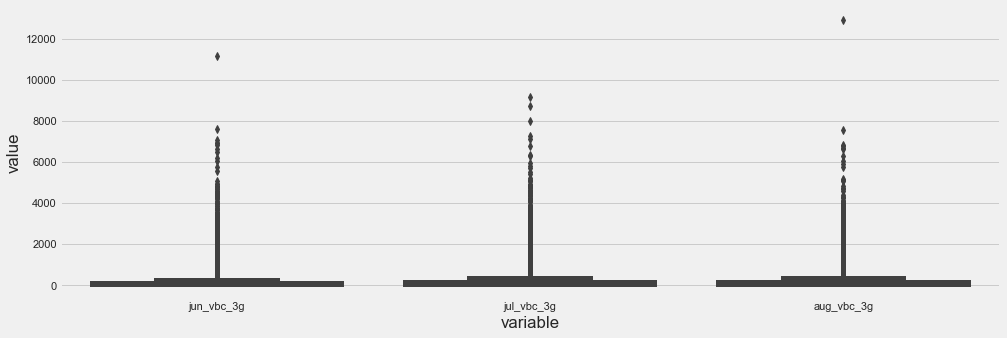

           Jun      Jul      Aug
churn                           
0     162.5573 186.3705 180.6226
1     115.4618  96.3407  40.9409


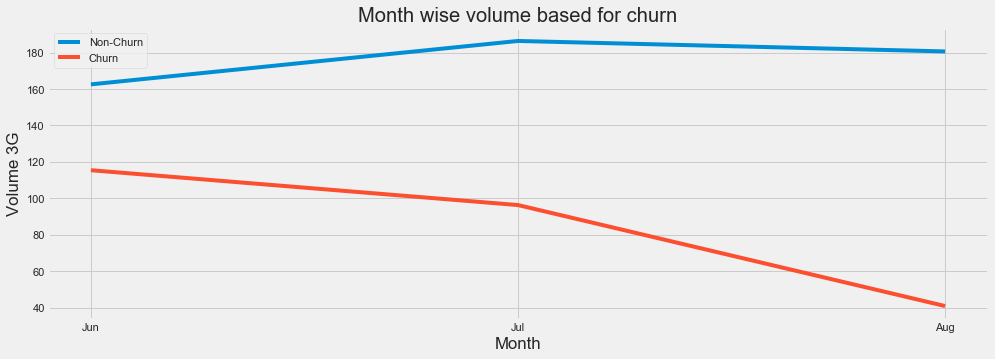

In [738]:
month_wise_analysis(['jun_vbc_3g', 'jul_vbc_3g', 'aug_vbc_3g'],
                    'Month wise volume based for churn', 'Month', 'Volume 3G')

We can see that the 3g volume mou decreases significantly for the churned customer from Jun to Aug. In case of non-churned customers it is almost constant. We can see there are outliers. We will treat them in outliers treatment section.

count   29953.0000
mean     1153.7017
std      1359.5336
min       478.5000
25%       604.0000
50%       800.5000
75%      1209.0000
max     61236.0000
Name: average_recharge_amount, dtype: float64


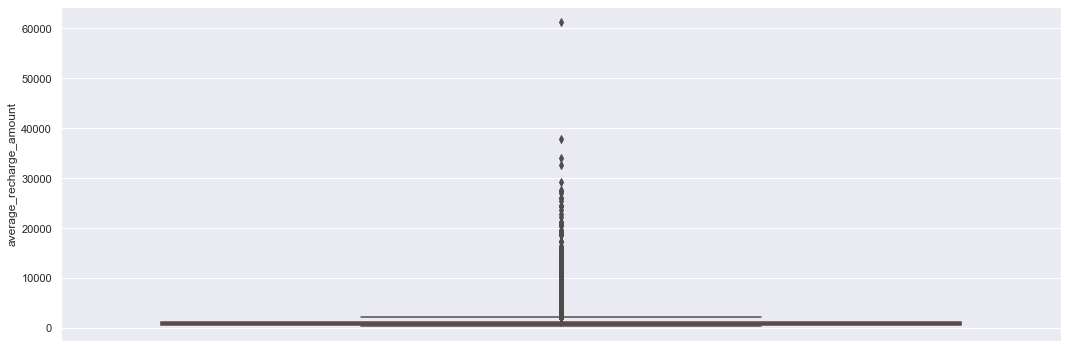

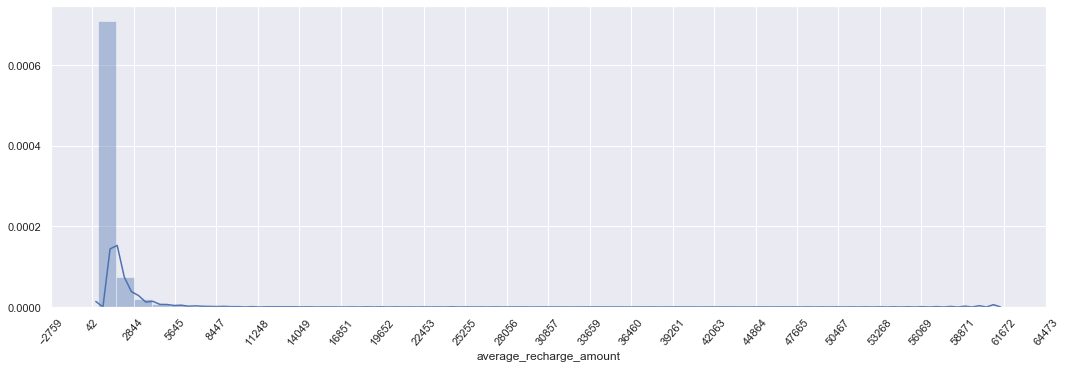

In [739]:
univariate_analysis('average_recharge_amount')

We can see that there are outliers here which makes sense as there will be some customers who pay huge money for recharge.

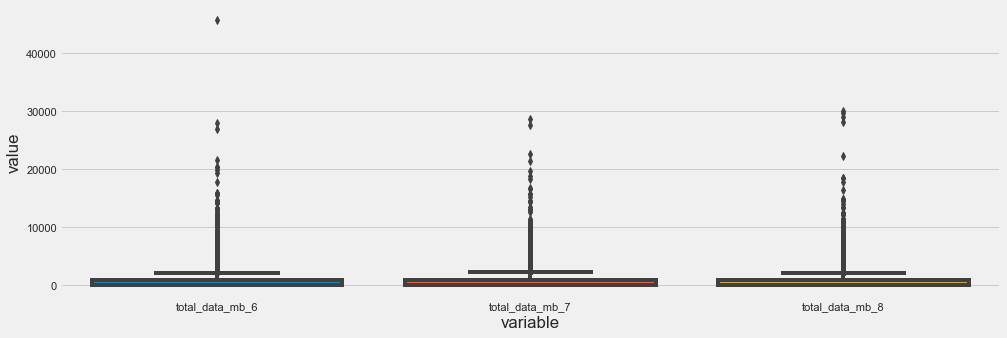

           Jun      Jul      Aug
churn                           
0     605.7925 640.2835 601.5430
1     506.2850 400.0708 134.1448


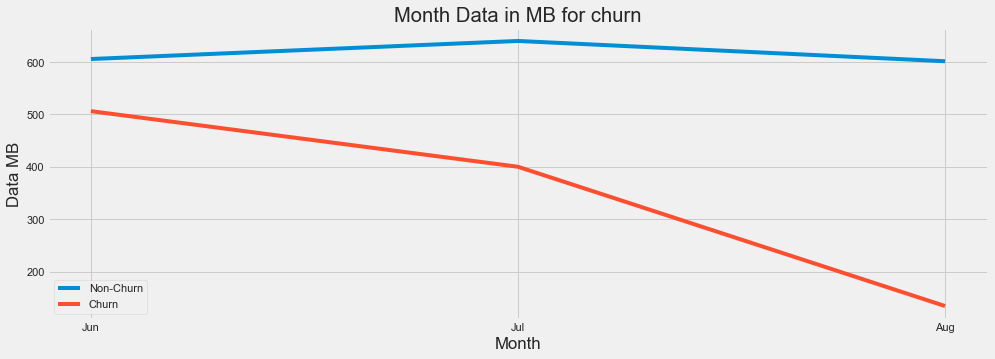

In [740]:
month_wise_analysis(['total_data_mb_6', 'total_data_mb_7', 'total_data_mb_8'],
                    'Month Data in MB for churn', 'Month', 'Data MB')

We can see that the total outgoing mou decreases significantly for the churned customer from Jun to Aug. In case of non-churned customers it is almost constant. We can see there are outliers. We will treat them in outliers treatment section.

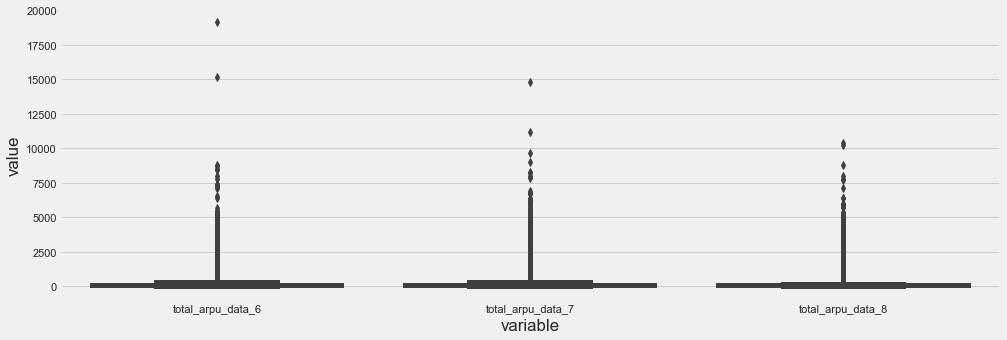

           Jun      Jul      Aug
churn                           
0     197.9403 206.9873 195.6237
1     195.2407 148.4653  53.9988


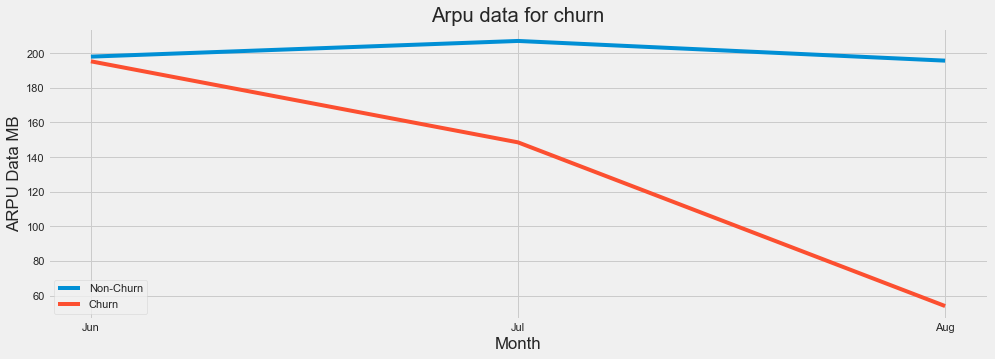

In [741]:
month_wise_analysis(['total_arpu_data_6', 'total_arpu_data_7', 'total_arpu_data_8'],
                    'Arpu data for churn', 'Month', 'ARPU Data MB')

We can see that the data arpu decreases significantly for the churned customer from Jun to Aug. In case of non-churned customers it is almost constant. We can see there are outliers. We will treat them in outliers treatment section.

## Outliers treatment 

We saw that there are many features which have outliers. However, we can remove all of them as it may impact the model accuracy. We will remove the rows which have more than 99 percentile for following features:

1. arpu
2. average_recharge_amount
3. total_data_mb
4. total_og_mou
5. total_arpu_data

In [742]:
outlier_features = ['arpu_6','arpu_7','average_recharge_amount','total_data_mb_6',
                    'total_data_mb_7','total_og_mou_6','total_og_mou_7','total_arpu_data_6',
                    'total_arpu_data_7']

for column in outlier_features:
    upper = telecom_data[column].quantile(.99)
    telecom_data = telecom_data[telecom_data[column] < upper]

In [743]:
telecom_data.shape

(27359, 124)

In [744]:
numerical_columns = telecom_data.select_dtypes(
    include=['int64', 'float64']).columns

columns_to_encode = telecom_data.select_dtypes(
    include=['category', 'object']).columns.tolist()
columns_to_encode.remove('churn')


In [745]:
# Creating the dummy variables and deleting the unknown class (-1) which we substituted for `NAN`
for c in columns_to_encode:
    dummy_pd = pd.get_dummies(telecom_data[c],
                              prefix=c)
    if((c + "-1") in dummy_pd.columns):
        dummy_pd = dummy_pd.drop((c+"-1"), axis=1)
    else:
        dummy_pd = dummy_pd.drop(dummy_pd.columns[0], axis=1)

    telecom_data = pd.concat([telecom_data, dummy_pd], axis=1)

In [746]:
# Deleting the original columns
telecom_data = telecom_data.drop(columns_to_encode, axis=1)

In [747]:
def heat_map(data):
    corr = data.corr()
    sns.set(rc={'figure.figsize': (20, 20)})
    plt.tight_layout()
    ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu',annot=True)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

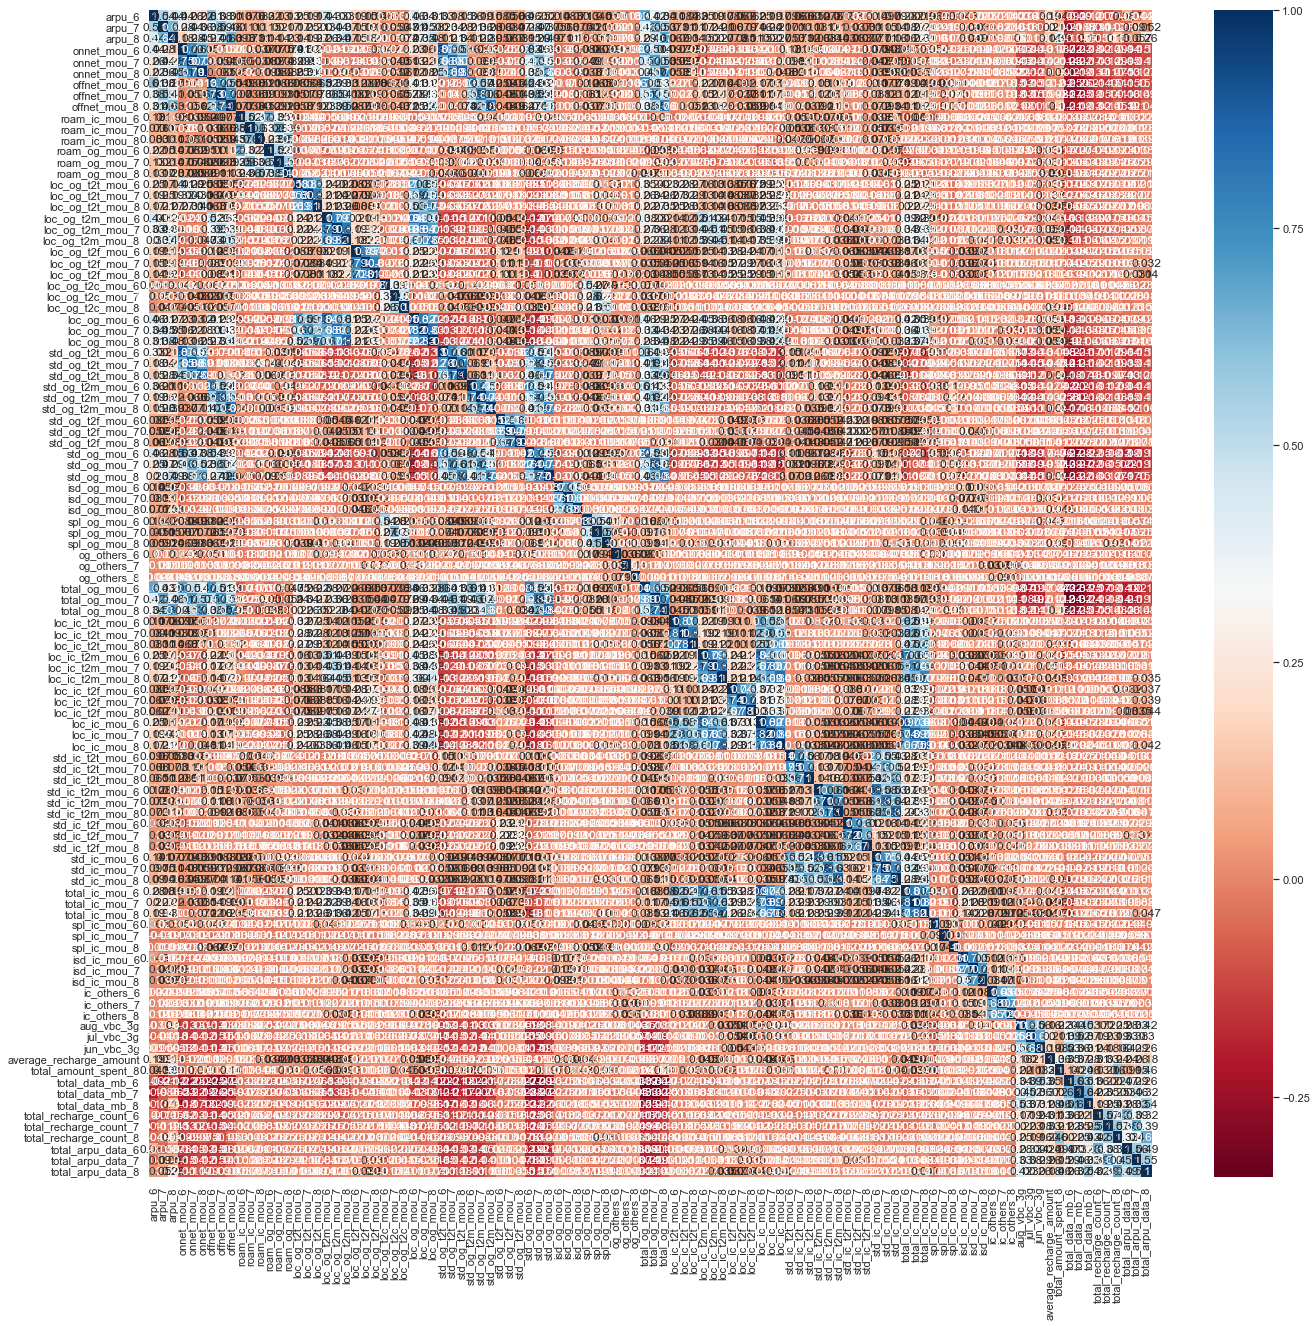

In [748]:
heat_map(telecom_data[numerical_columns])

In [749]:
# Reference https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/

# List of correlated columns

corr_matrix = telecom_data[numerical_columns].corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.80
to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]
print('found ',len(to_drop),' highly correlated features.')
print(to_drop)


found  26  highly correlated features.
['loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8', 'loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'std_ic_mou_6', 'std_ic_mou_7', 'std_ic_mou_8', 'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8']


We found 26 features which are around 80% correlated. We will not be deleting them as we will use PCA for dimension reduction.

In [750]:
## Saving the cleaned data 
from pathlib import Path
def save_clean_data():
    clean_file = Path("clean_data.csv")
    if clean_file.is_file():
        telecom_data = pd.read_csv('clean_data.csv')
    else:
        telecom_data.to_csv('clean_data.csv',header=True)

# Class imbalance

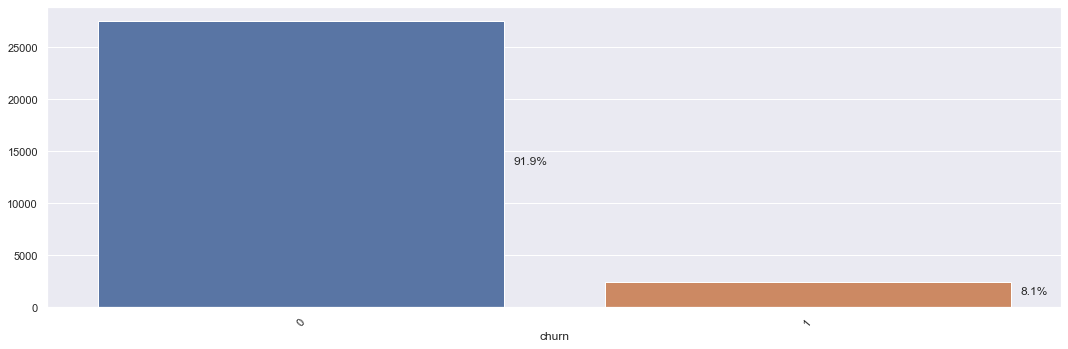

In [752]:
univariate_analysis('churn', is_categorical=True)

We can see that churn class is highly imbalanced. We will `SMOTE` to over sample the less frequent class.

In [754]:
random_seed = 101

In [755]:
y = telecom_data.pop('churn')
X = telecom_data

In [756]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size=0.7,
                                                    test_size=0.3,
                                                    random_state=random_seed)

In [757]:
# We will scale the data as PCA is senstive to the scale.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [758]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=random_seed)

X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train)

from collections import Counter
print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_resampled))

Before SMOTE: Counter({0: 17676, 1: 1475})
After SMOTE: Counter({0: 17676, 1: 17676})


## PCA

In [759]:
from sklearn.decomposition import PCA

In [760]:
pca = PCA(random_state=random_seed)

In [761]:
pca.fit(X_train_resampled)

PCA(random_state=101)

In [762]:
pca.explained_variance_ratio_

array([1.12554136e-01, 8.77989598e-02, 4.87206218e-02, 4.32857160e-02,
       3.98168877e-02, 3.53703265e-02, 2.90286446e-02, 2.67471406e-02,
       2.08638904e-02, 1.97186128e-02, 1.87554682e-02, 1.76334888e-02,
       1.62879469e-02, 1.57739955e-02, 1.55231879e-02, 1.50715021e-02,
       1.41303411e-02, 1.33698598e-02, 1.31875572e-02, 1.29102263e-02,
       1.16511329e-02, 1.14970489e-02, 1.13033048e-02, 1.07768413e-02,
       9.90896029e-03, 9.66372306e-03, 8.99637713e-03, 8.82192419e-03,
       8.60317188e-03, 8.38623792e-03, 8.30493860e-03, 7.97901626e-03,
       7.63670409e-03, 7.54878920e-03, 7.32948698e-03, 7.16233426e-03,
       6.94616029e-03, 6.63808868e-03, 6.53675539e-03, 6.50332737e-03,
       6.41388171e-03, 6.36517067e-03, 6.28463285e-03, 6.19517459e-03,
       6.01409492e-03, 5.91455727e-03, 5.90166567e-03, 5.72933553e-03,
       5.63339606e-03, 5.56534614e-03, 5.39577987e-03, 5.30195713e-03,
       5.08937796e-03, 4.96289495e-03, 4.88974288e-03, 4.78203678e-03,
      

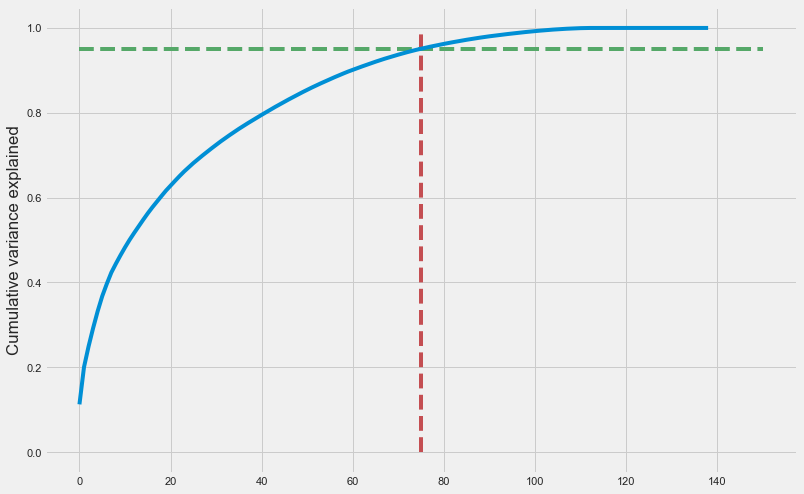

In [763]:
# Making a scree plot for the explained variance
var_cumu = np.cumsum(pca.explained_variance_ratio_)
fig = plt.figure(figsize=[12,8])
plt.vlines(x=75, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.95, xmax=150, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.show()

From the graph we can see that 95% variance of the data. From now onwards, we will consider 75 components for the analysis

In [764]:
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=75)
X_train_pca = pca_final.fit_transform(X_train_resampled)
X_train_pca.shape

(35352, 75)

In [765]:
# Getting the minimum and maximum value from the correlation matrix.
# Reference https://stackoverflow.com/questions/29394377/minimum-of-numpy-array-ignoring-diagonal

corr_matrix = np.corrcoef(X_train_pca.transpose())
mask = np.ones(corr_matrix.shape, dtype=bool)
np.fill_diagonal(mask, 0)
max_value = corr_matrix[mask].max()
min_value = corr_matrix[mask].min()

print('Max: ', max_value, ' , Min: ', min_value )

Max:  0.021094020167481152  , Min:  -0.026465719581756905


We can say that after PCA, there is no multi collinearity in the data set.

Applying the transformation on the test set

In [766]:
X_test_pca = pca_final.transform(X_test)
X_test_pca.shape

(8208, 75)

# Model creation

## With PCA

We will be creating following model:
1. DummyClassifier (Base Model)
2. Logistic Regression
3. Decision Tree
4. Random Forest
5. Boosting models

In [918]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from time import time

In [828]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, thresholds

In [883]:
def train_model(classifier_name, classifier, X_train_model, y_train_model,
                X_test_model, y_test_model):
    start = time()
    classifier.fit(X_train_model, y_train_model)
    df_train = predict_and_get_metrics('train', classifier, X_train_model,
                                       y_train_model)
    train_time = time() - start
    start = time()
    df_test = predict_and_get_metrics('test', classifier, X_test_model,
                                      y_test_model)
    df = pd.concat([df_train, df_test], axis=1)
    df.insert(0, "name", [classifier_name], True)
    score_time = time()-start
    print("ModelName: {:<15} | time (training/test) = {:,.3f}s/{:,.3f}s".format(classifier_name, train_time, score_time))
    return df

In [830]:
def predict_and_get_metrics(score_type, classifier, X_model, y_model):
    y_pred = classifier.predict(X_model)
    y_pred_prob = classifier.predict_proba(X_model)[:, 1]
    if(score_type=='test'):
        draw_roc(y_model, y_pred_prob)
    accuracy = accuracy_score(y_model, y_pred)
    precision = precision_score(y_model, y_pred)
    recall = recall_score(y_model, y_pred)
    f1 = f1_score(y_model, y_pred)
    auc = roc_auc_score(y_model, y_pred_prob)

    metrics_dict = {}
    metrics_dict[score_type + '_accuracy'] = accuracy
    metrics_dict[score_type + '_precision'] = precision
    metrics_dict[score_type + '_recall'] = recall
    metrics_dict[score_type + '_f1'] = f1
    metrics_dict[score_type + '_auc'] = auc
    records = []
    records.append(metrics_dict)
    return pd.DataFrame.from_records(records)

In [929]:
def hyperparameter_tuning(classifier,
                          params_grid,
                          n_folds=5,
                          scoring='recall',
                          X_train=X_train_pca):
    grid_search = GridSearchCV(estimator=classifier,
                               param_grid=params_grid,
                               cv=n_folds,
                               verbose=1,
                               n_jobs=-1,
                               scoring=scoring)
    grid_search.fit(X_train, y_train_resampled)
    print(grid_search.best_estimator_)

## Baseline Model

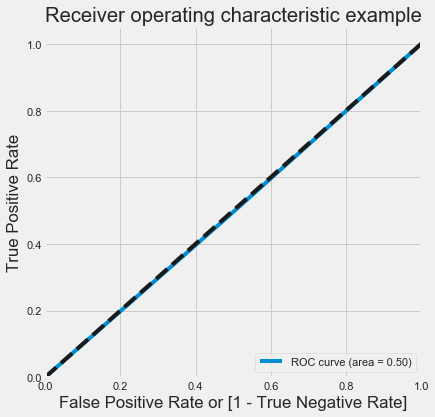

name  train_accuracy  train_precision  train_recall  train_f1  \
0  base_line          0.5006           0.5006        0.5004    0.5005   

   train_auc  test_accuracy  test_precision  test_recall  test_f1  test_auc  
0     0.5006         0.5011          0.0785       0.4938   0.1355    0.4978

In [835]:
base_line_model = DummyClassifier(random_state=random_seed)

model_metrics = train_model('base_line', base_line_model, X_train_pca, y_train_resampled,
            X_test_pca, y_test)
model_metrics

## Logistic Regression

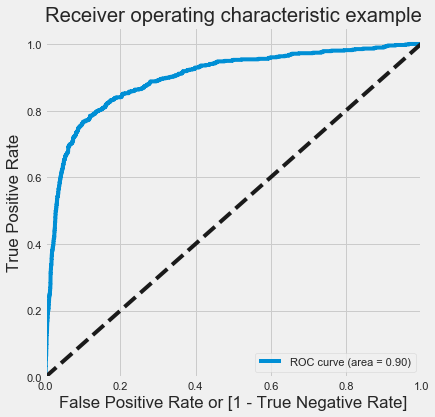

ModelName: logistic_regression | time (training/test) = 0.302s/0.243s


name  train_accuracy  train_precision  train_recall  \
0  logistic_regression          0.8477           0.8349        0.8668   

   train_f1  train_auc  test_accuracy  test_precision  test_recall  test_f1  \
0    0.8506     0.9157         0.8235          0.2874       0.8308   0.4270   

   test_auc  
0    0.8967

In [884]:
logistic_model = LogisticRegression(random_state=random_seed)

df = train_model('logistic_regression', logistic, X_train_pca, y_train_resampled,
            X_test_pca, y_test)
model_metrics = pd.concat([model_metrics,df],axis=0)
df

## Decision Tree

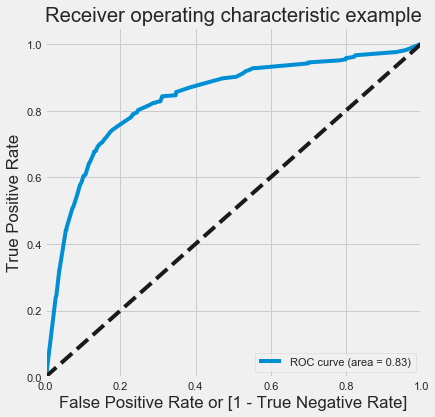

name  train_accuracy  train_precision  train_recall  \
0  decision_tree_default          0.8479           0.8521        0.8418   

   train_f1  train_auc  test_accuracy  test_precision  test_recall  test_f1  \
0    0.8469     0.9110         0.8291          0.2768       0.7185   0.3997   

   test_auc  
0    0.8350

In [852]:
decision_tree_model = DecisionTreeClassifier(random_state=random_seed,
                                             max_depth=7,
                                             min_samples_leaf=1,
                                             min_samples_split=2)

df = train_model('decision_tree_default', decision_tree_model, X_train_pca,
                 y_train_resampled, X_test_pca, y_test)
model_metrics = pd.concat([model_metrics, df], axis=0)
df

### Hyperparameter tuning

In [872]:
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
    'criterion': ["entropy", "gini"]
}
hyperparameter_tuning(DecisionTreeClassifier(), param_grid)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   19.6s finished


DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=50,
                       min_samples_split=50)


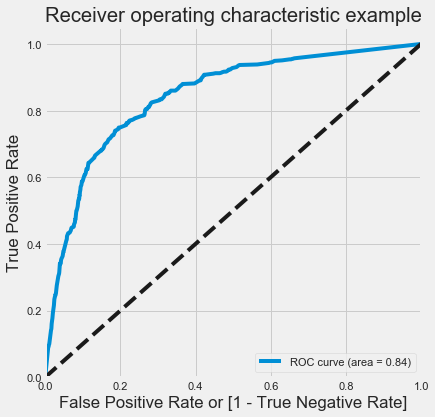

name  train_accuracy  train_precision  train_recall  \
0  decision_tree_tuned          0.8641           0.8565        0.8746   

   train_f1  train_auc  test_accuracy  test_precision  test_recall  test_f1  \
0    0.8655     0.9441         0.8185          0.2630       0.7169   0.3848   

   test_auc  
0    0.8425

In [857]:
decision_tree_model = DecisionTreeClassifier(random_state=random_seed,
                                             criterion='entropy',
                                             max_depth=10,
                                             min_samples_leaf=50,
                                             min_samples_split=50)
df = train_model('decision_tree_tuned', decision_tree_model, X_train_pca,
                 y_train_resampled, X_test_pca, y_test)
model_metrics = pd.concat([model_metrics, df], axis=0)
df

## Random Forest

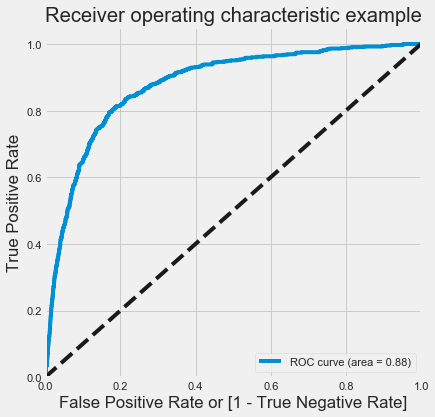

name  train_accuracy  train_precision  train_recall  \
0  random_forest_default          0.8766           0.8756        0.8779   

   train_f1  train_auc  test_accuracy  test_precision  test_recall  test_f1  \
0    0.8768     0.9436         0.8492          0.3113       0.7462   0.4393   

   test_auc  
0    0.8771

In [853]:
random_forest_model = RandomForestClassifier(random_state=random_seed,
                                             n_estimators=100,
                                             max_depth=7,
                                             min_samples_leaf=1,
                                             min_samples_split=2)

df = train_model('random_forest_default', random_forest_model, X_train_pca,
                 y_train_resampled, X_test_pca, y_test)
model_metrics = pd.concat([model_metrics, df], axis=0)
df

### Hyperparameter tuning

This hyper parameter tuning for Random Forest takes around **4** minutes on a machine with 32 GB ram and 12 processor

In [873]:
param_grid = {
    'max_depth': range(4, 8, 10),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
    'n_estimators': [100, 150, 200],
    'max_features': [5, 10]
}
hyperparameter_tuning(RandomForestClassifier(), param_grid)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  3.3min finished


RandomForestClassifier(max_depth=4, max_features=5, min_samples_leaf=100,
                       min_samples_split=100, n_estimators=200)


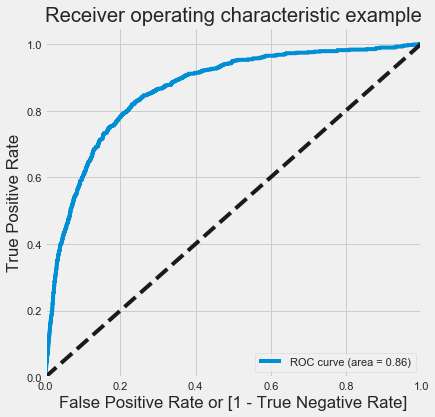

name  train_accuracy  train_precision  train_recall  \
0  random_forest_tuned          0.8225           0.8389        0.7984   

   train_f1  train_auc  test_accuracy  test_precision  test_recall  test_f1  \
0    0.8181     0.9030         0.8311          0.2820       0.7323   0.4072   

   test_auc  
0    0.8628

In [874]:
random_forest_model = RandomForestClassifier(random_state=random_seed,
                                             n_estimators=200,
                                             max_depth=4,
                                             min_samples_leaf=100,
                                             min_samples_split=100)

df = train_model('random_forest_tuned', random_forest_model, X_train_pca,
                 y_train_resampled, X_test_pca, y_test)
model_metrics = pd.concat([model_metrics, df], axis=0)
df

## AdaBoost

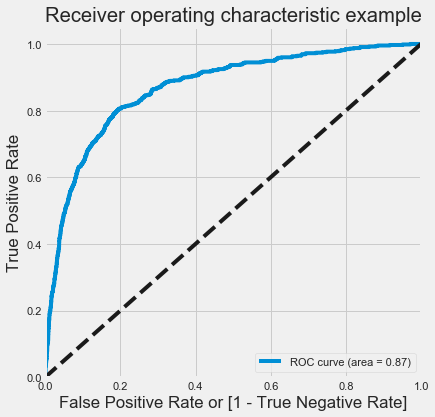

ModelName: adaboost_default | time (training/test) = 122.733s/0.603s


name  train_accuracy  train_precision  train_recall  train_f1  \
0  adaboost_default          0.8917           0.8838        0.9019    0.8928   

   train_auc  test_accuracy  test_precision  test_recall  test_f1  test_auc  
0     0.9583         0.8460          0.3024       0.7231   0.4265    0.8681

In [885]:
weak_learner = DecisionTreeClassifier(max_depth=2, random_state=random_seed)

adaboost = AdaBoostClassifier(base_estimator=weak_learner,
                              n_estimators=200,
                              learning_rate=1.5,
                              algorithm="SAMME")

df = train_model('adaboost_default', adaboost, X_train_pca,
                 y_train_resampled, X_test_pca, y_test)
model_metrics = pd.concat([model_metrics, df], axis=0)
df

### Hyperparameter tuning

This hyper parameter tuning for AdaBoost Classifier takes around **15** minutes on a machine with 32 GB ram and 12 processor

In [890]:
param_grid = {
    "base_estimator__max_depth": [2, 4],
    "n_estimators": [200, 300],
    "learning_rate": [.3, .9, .3]
}

tree = DecisionTreeClassifier(random_state=random_seed)

ABC = AdaBoostClassifier(base_estimator=tree, algorithm="SAMME")

hyperparameter_tuning(ABC, param_grid, 3, 'roc_auc')

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 15.0min finished


AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=4),
                   learning_rate=0.9, n_estimators=300)


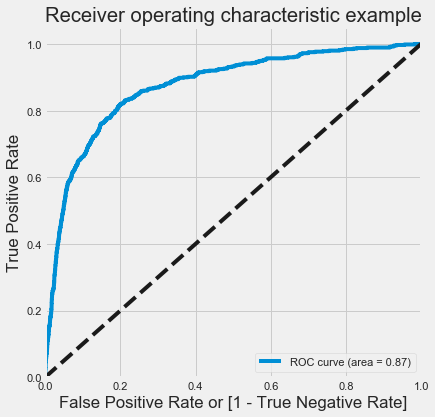

ModelName: adaboost_tuned  | time (training/test) = 327.726s/0.807s


name  train_accuracy  train_precision  train_recall  train_f1  \
0  adaboost_tuned          0.9807           0.9700        0.9921    0.9809   

   train_auc  test_accuracy  test_precision  test_recall  test_f1  test_auc  
0     0.9988         0.8939          0.3945       0.6354   0.4867    0.8730

In [892]:
weak_learner = DecisionTreeClassifier(max_depth=4, random_state=random_seed)

adaboost = AdaBoostClassifier(base_estimator=weak_learner,
                              n_estimators=300,
                              learning_rate=0.9,
                              algorithm="SAMME")

df = train_model('adaboost_tuned', adaboost, X_train_pca, y_train_resampled,
                 X_test_pca, y_test)
model_metrics = pd.concat([model_metrics, df], axis=0)
df

## Gradient Boosting Classifier

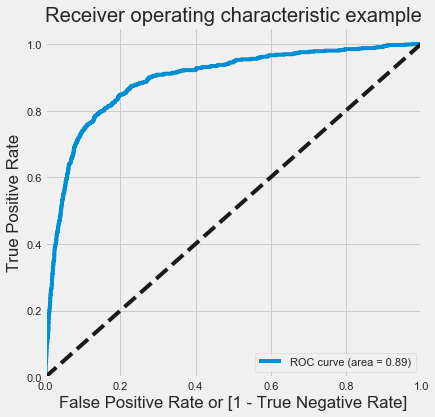

ModelName: gradient_boost_default | time (training/test) = 108.928s/0.232s


name  train_accuracy  train_precision  train_recall  \
0  gradient_boost_default          0.8708           0.8679        0.8746   

   train_f1  train_auc  test_accuracy  test_precision  test_recall  test_f1  \
0    0.8712     0.9389         0.8498          0.3197       0.7954   0.4561   

   test_auc  
0    0.8918

In [895]:
GBC = GradientBoostingClassifier(max_depth=2, n_estimators=200, random_state=random_seed)
df = train_model('gradient_boost_default', GBC, X_train_pca, y_train_resampled,
                 X_test_pca, y_test)
model_metrics = pd.concat([model_metrics, df], axis=0)
df

### Hyperparameter tuning

This hyper parameter tuning for Gradient Boosting Classifier takes around **4** minutes on a machine with 32 GB ram and 12 processor

In [901]:
param_grid = {"learning_rate": [0.2, 0.6, 0.9], "subsample": [0.3, 0.6, 0.9]}
GBC = GradientBoostingClassifier(max_depth=2,
                                 n_estimators=200,
                                 random_state=random_seed)
hyperparameter_tuning(GBC, param_grid, n_folds=3)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  3.3min finished


GradientBoostingClassifier(learning_rate=0.9, max_depth=2, n_estimators=200,
                           subsample=0.9)


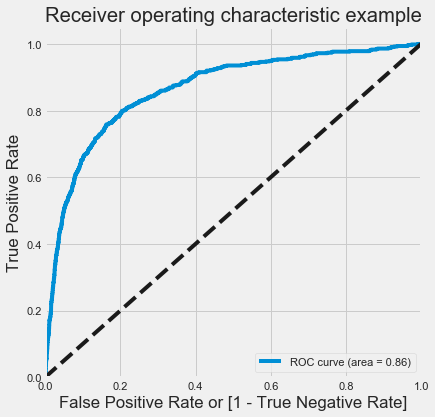

ModelName: gradient_boost_tuned | time (training/test) = 95.782s/0.251s


name  train_accuracy  train_precision  train_recall  \
0  gradient_boost_tuned          0.9336           0.9197        0.9502   

   train_f1  train_auc  test_accuracy  test_precision  test_recall  test_f1  \
0    0.9347     0.9779         0.8654          0.3316       0.6892   0.4478   

   test_auc  
0    0.8641

In [902]:
GBC = GradientBoostingClassifier(max_depth=2,
                                 n_estimators=200,
                                 learning_rate=0.9,
                                 subsample=0.9,
                                 random_state=random_seed)
df = train_model('gradient_boost_tuned', GBC, X_train_pca, y_train_resampled,
                 X_test_pca, y_test)
model_metrics = pd.concat([model_metrics, df], axis=0)
df

## XGBoost

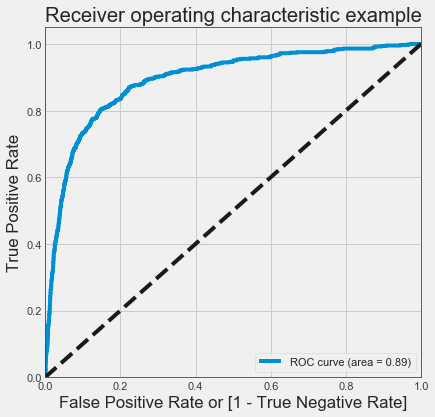

ModelName: xgboost_default | time (training/test) = 30.616s/0.376s


name  train_accuracy  train_precision  train_recall  train_f1  \
0  xgboost_default          0.8702           0.8667        0.8751    0.8709   

   train_auc  test_accuracy  test_precision  test_recall  test_f1  test_auc  
0     0.9386         0.8528          0.3245       0.7938   0.4607    0.8923

In [920]:
xgb = XGBClassifier(max_depth=2,
                    n_estimators=200,
                    nthread=-1,
                    random_state=random_seed)
df = train_model('xgboost_default', xgb, X_train_pca, y_train_resampled,
                 X_test_pca, y_test)
model_metrics = pd.concat([model_metrics, df], axis=0)
df

### Hyperparameter tuning

This hyper parameter tuning for XGBoostClassifier takes around **12** minutes on a machine with 32 GB ram and 12 processor

In [924]:
param_grid = {
    "learning_rate": [0.1, 0.2, 0.3],
    "subsample": [0.3, 0.6, 0.9],
    'n_estimators': [200, 400, 600]
}
xgb = XGBClassifier(max_depth=2,
                    n_estimators=200,
                    nthread=-1,
                    random_state=random_seed)
hyperparameter_tuning(xgb, param_grid, n_folds=3)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  8.9min finished


XGBClassifier(learning_rate=0.3, max_depth=2, n_estimators=600, nthread=-1,
              random_state=101, subsample=0.9)


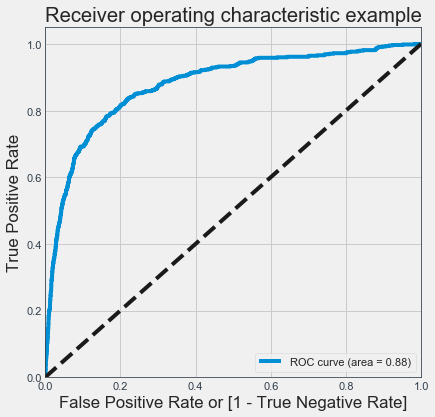

ModelName: xgboost_tuned   | time (training/test) = 85.784s/0.388s


name  train_accuracy  train_precision  train_recall  train_f1  \
0  xgboost_tuned          0.9446           0.9268        0.9653    0.9457   

   train_auc  test_accuracy  test_precision  test_recall  test_f1  test_auc  
0     0.9846         0.8768          0.3589       0.7062   0.4759    0.8774

In [925]:
xgb = XGBClassifier(max_depth=2,
                    n_estimators=600,
                    nthread=-1,
                    learning_rate=0.3,
                    subsample=0.9)

df = train_model('xgboost_tuned', xgb, X_train_pca, y_train_resampled,
                 X_test_pca, y_test)
model_metrics = pd.concat([model_metrics, df], axis=0)
df

## Model evaluation

In [926]:
model_metrics

name  train_accuracy  train_precision  train_recall  \
0     logistic_regression          0.8477           0.8349        0.8668   
0     logistic_regression          0.8477           0.8349        0.8668   
0     logistic_regression          0.8477           0.8349        0.8668   
0     logistic_regression          0.8477           0.8349        0.8668   
0     logistic_regression          0.8477           0.8349        0.8668   
0  gradient_boost_default          0.8708           0.8679        0.8746   
0   random_forest_default          0.8766           0.8756        0.8779   
0     random_forest_tuned          0.8225           0.8389        0.7984   
0    gradient_boost_tuned          0.9233           0.9096        0.9401   
0        adaboost_default          0.8917           0.8838        0.9019   
0           decision_tree          0.8479           0.8521        0.8418   
0   decision_tree_default          0.8479           0.8521        0.8418   
0     decision_tree_tuned          0.8641           0.8565        0.8746   
0     decision_tree_tuned          0.8641           0.8565        0.8746   
0    gradient_boost_tuned          0.9336           0.9197        0.9502   
0          adaboost_tuned          0.9807           0.9700        0.9921   
0               base_line          0.5006           0.5006        0.5004   
0         xgboost_default          0.8702           0.8667        0.8751   
0         xgboost_default          0.8702           0.8667        0.8751   
0           xgboost_tuned          0.9351           0.9200        0.9532   
0           xgboost_tuned          0.9446           0.9268        0.9653   

   train_f1  train_auc  test_accuracy  test_precision  test_recall  test_f1  \
0    0.8506     0.9157         0.8235          0.2874       0.8308   0.4270   
0    0.8506     0.9157         0.8235          0.2874       0.8308   0.4270   
0    0.8506     0.9157         0.8235          0.2874       0.8308   0.4270   
0    0.8506     0.9157         0.8235          0.2874       0.8308   0.4270   
0    0.8506     0.9157         0.8235          0.2874       0.8308   0.4270   
0    0.8712     0.9389         0.8498          0.3197       0.7954   0.4561   
0    0.8768     0.9436         0.8492          0.3113       0.7462   0.4393   
0    0.8181     0.9030         0.8311          0.2820       0.7323   0.4072   
0    0.9246     0.9730         0.8637          0.3338       0.7246   0.4571   
0    0.8928     0.9583         0.8460          0.3024       0.7231   0.4265   
0    0.8469     0.9110         0.8291          0.2768       0.7185   0.3997   
0    0.8469     0.9110         0.8291          0.2768       0.7185   0.3997   
0    0.8655     0.9441         0.8185          0.2630       0.7169   0.3848   
0    0.8655     0.9441         0.8185          0.2630       0.7169   0.3848   
0    0.9347     0.9779         0.8654          0.3316       0.6892   0.4478   
0    0.9809     0.9988         0.8939          0.3945       0.6354   0.4867   
0    0.5005     0.5006         0.5011          0.0785       0.4938   0.1355   
0    0.8709     0.9386         0.8528          0.3245       0.7938   0.4607   
0    0.8709     0.9386         0.8528          0.3245       0.7938   0.4607   
0    0.9363     0.9797         0.8676          0.3361       0.6892   0.4518   
0    0.9457     0.9846         0.8768          0.3589       0.7062   0.4759   

   test_auc  
0    0.8967  
0    0.8967  
0    0.8967  
0    0.8967  
0    0.8967  
0    0.8918  
0    0.8771  
0    0.8628  
0    0.8735  
0    0.8681  
0    0.8350  
0    0.8350  
0    0.8425  
0    0.8425  
0    0.8641  
0    0.8730  
0    0.4978  
0    0.8923  
0    0.8923  
0    0.8679  
0    0.8774

Text(0, 0.5, 'Recall')

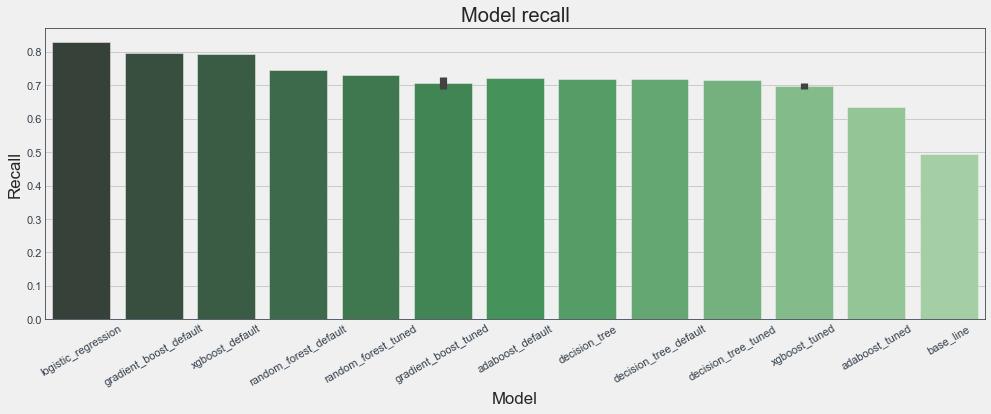

In [927]:
model_metrics = model_metrics.sort_values(by='test_recall', ascending=False)
sns.barplot(model_metrics['name'],
            model_metrics['test_recall'],
            palette='Oranges_d')
plt.xticks(rotation=30, horizontalalignment="center")
plt.title("Model recall")
plt.xlabel("Model")
plt.ylabel("Recall")
plt.show()

In this problem, data points corresponding to the target class is very less in number. Thus max `recall` will be the metrics which we will be targeting for. **We want to reduce *Type 2* error which *False Negative*.**

We created baseline model which always selected a single class. This model resulted in a recall value of around **.50**. 

As we can see from the above chart and the table that the ***Logistic Regression*** has the best *recall* value of ***0.83***. Default ***Gradient Boost Classifier*** has the next best *recall* value of ***0.79***. Other boosting classifiers worked well on the training data however, performed poorly on the test data.

Thus we will be selecting ***Logistic Regression*** as our final classifier

# Important features for churn

As suggested in the problem statement, we can either use *Logistic Regression* or *Random Forest* to identify the most important features. We will be using ***Random Forest*** as we need not handle multi collinearity of the features. 

In [987]:
def plot_important_features(classifer):
    importance = dict(zip(X.columns, classifer.feature_importances_))
    importance_list = []
    importance_list.append(importance)
    df = pd.DataFrame.from_dict(importance_list).T.reset_index()
    df.columns = ['feature', 'importance']
    df = df.sort_values(by='importance', ascending=False)
    df = df.head(35)
    sns.set(rc={'figure.figsize': (20, 10)})
    sns.barplot(df['feature'],
            df['importance'],
            palette='Oranges_d')
    plt.xticks(rotation=90, horizontalalignment="center")
    plt.title("Feature Importance")
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.show()
    return df

The following hyper parameter tuning will take around *30 minutes* on a machine with 32GB ram and 12 processors.

In [931]:
param_grid = {
    'max_depth': range(4, 12, 4),
    'min_samples_leaf': range(50, 200, 50),
    'min_samples_split': range(50, 200, 50),
    'n_estimators': range(100, 500, 100),
    'max_features': range(5, 20, 5)
}
hyperparameter_tuning(RandomForestClassifier(random_state=random_seed),
                      param_grid,
                      n_folds=3,
                      X_train=X_train_resampled)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed: 29.0min finished


RandomForestClassifier(max_depth=8, max_features=15, min_samples_leaf=50,
                       min_samples_split=50, n_estimators=400)


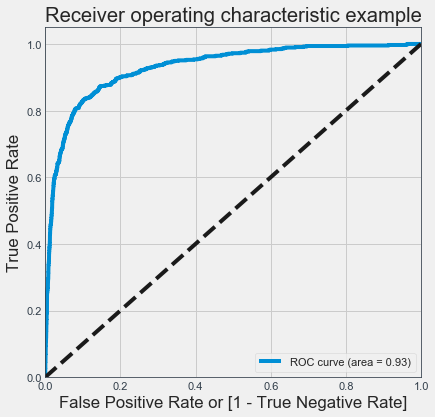

ModelName: random_forest   | time (training/test) = 53.296s/0.898s


name  train_accuracy  train_precision  train_recall  train_f1  \
0  random_forest          0.9162           0.9207        0.9109    0.9158   

   train_auc  test_accuracy  test_precision  test_recall  test_f1  test_auc  
0     0.9702         0.9058          0.4476       0.8077   0.5760    0.9297

In [935]:
random_forest_model = RandomForestClassifier(random_state=random_seed,
                                             n_estimators=400,
                                             max_depth=8,
                                             max_features=15,
                                             min_samples_leaf=50,
                                             min_samples_split=50)

df = train_model('random_forest', random_forest_model, X_train_resampled,
                 y_train_resampled, X_test, y_test)
df

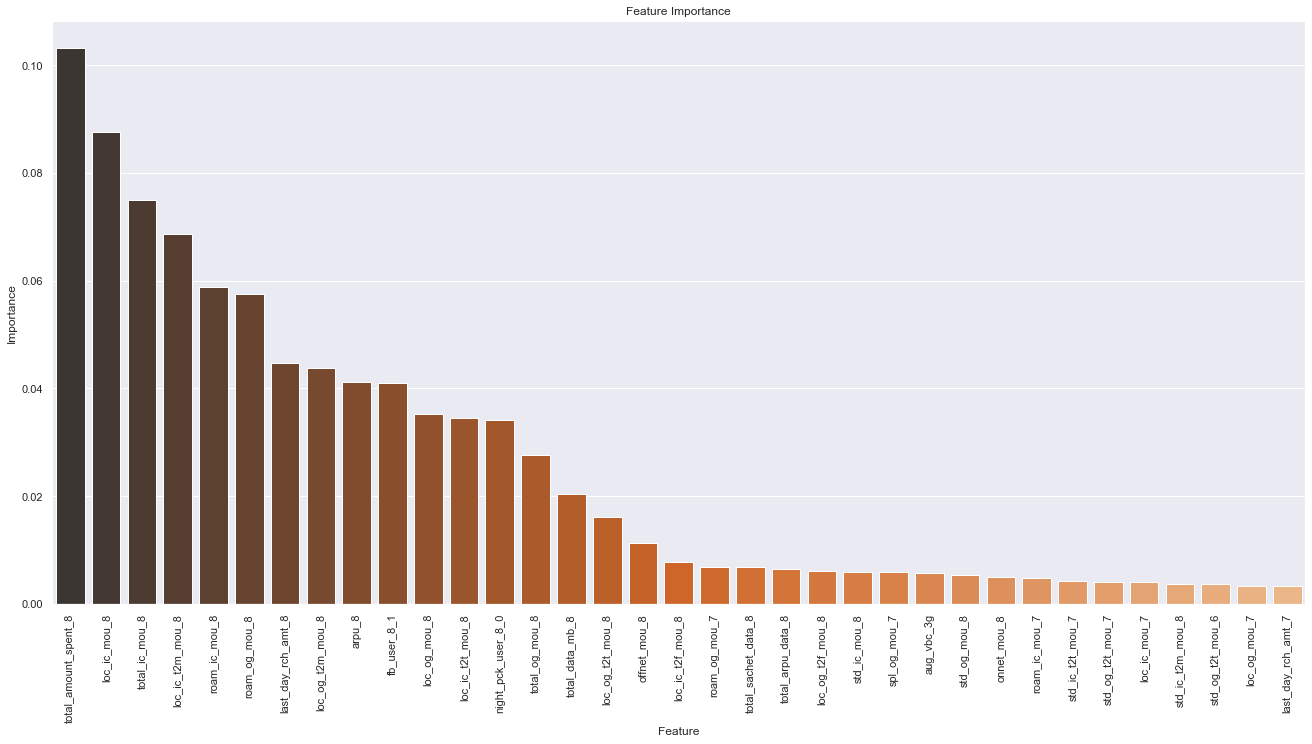

In [988]:
features = plot_important_features(random_forest_model)

In [989]:
features.reset_index()

index               feature  importance
0     103  total_amount_spent_8      0.1031
1      65          loc_ic_mou_8      0.0875
2      80        total_ic_mou_8      0.0749
3      59      loc_ic_t2m_mou_8      0.0686
4      11         roam_ic_mou_8      0.0588
5      14         roam_og_mou_8      0.0575
6      92    last_day_rch_amt_8      0.0446
7      20      loc_og_t2m_mou_8      0.0438
8       2                arpu_8      0.0412
9     127           fb_user_8_1      0.0410
10     29          loc_og_mou_8      0.0353
11     56      loc_ic_t2t_mou_8      0.0345
12    120    night_pck_user_8_0      0.0342
13     53        total_og_mou_8      0.0276
14    106       total_data_mb_8      0.0204
15     17      loc_og_t2t_mou_8      0.0162
16      8          offnet_mou_8      0.0113
17     62      loc_ic_t2f_mou_8      0.0078
18     13         roam_og_mou_7      0.0069
19    115   total_sachet_data_8      0.0069
20    112     total_arpu_data_8      0.0066
21     23      loc_og_t2f_mou_8      0.0061
22     77          std_ic_mou_8      0.0060
23     46          spl_og_mou_7      0.0059
24     99            aug_vbc_3g      0.0058
25     41          std_og_mou_8      0.0054
26      5           onnet_mou_8      0.0050
27     10         roam_ic_mou_7      0.0048
28     67      std_ic_t2t_mou_7      0.0042
29     31      std_og_t2t_mou_7      0.0042
30     64          loc_ic_mou_7      0.0040
31     71      std_ic_t2m_mou_8      0.0037
32     30      std_og_t2t_mou_6      0.0036
33     28          loc_og_mou_7      0.0033
34     91    last_day_rch_amt_7      0.0033